# Admixture

* I estimated admixture proportions using NGSadmix with genotype likelihoods across all samples (minus related individuals) in each pair of urban-rural environement estimated in ANGSD
 - I ran all K values from 2 to 10 10 times, each with a different random seed
 - Uses same 4fold SNPs as above
* I used Evanno's delta-K method implemented in CLUMPAK to estimate the upper-most level of structure (i.e., "optimal" K)

## Setup

In [1]:
# Libraries
library("IRdisplay")
library(tidyverse)
library(wesanderson)
library(RColorBrewer)
library(ggpubr)


── Attaching packages ───────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ──────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# Path to results for this project
results_prefix <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/'


In [3]:
# Function to load NGSadmix log files
load_ngsadmix_log <- function(path){
    seed <- as.numeric(str_extract(basename(path), pattern = '(?<=seed)[0-9]+(?=\\.log)'))
    
    logfile <- readLines(path)[9]  ## 9 index is for line with likelihood
    like <- as.numeric(str_extract(logfile, pattern = '(?<=like=)-[0-9]+\\.[0-9]+'))
    
    df_out <- data.frame(seed = seed, like = like)
    return(df_out)
}

In [4]:
# File of samples order per city
list<-c("Albuquerque", "Antwerp", "Armidale","Athens","Buenos_Aires",
        "Calgary","Cape_Town","Christchurch","Kunming","Landshut","Linkoping","Loja","Memphis",
        "Mexico_City","Munich","Palmerston_North","Punta_Arenas","Quito","Sapporo","Tehran",
        "Thessaloniki","Toronto","Vancouver","Warsaw")
samples<-as.data.frame(read.table("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t"))
samples$site<-gsub("u","tem",as.character(samples$site))
samples$site<-gsub("r","Rural",as.character(samples$site))
samples$site<-gsub("tem","Urban",as.character(samples$site))
for (city in list){
    detail <- read.table(paste0("/scratch/projects/trifolium/glue/demography/glue_demography/results/program_resources/bam_lists/by_city/withoutRelated/",city,"/",city,"_4fold_lowCovRemoved_bams.list"))
    detail$V1<-gsub("/scratch/projects/trifolium/glue/pc/results/bam/4fold/","",as.character(detail$V1))
    detail$V1<-gsub("_4fold.bam","",as.character(detail$V1))
    name <-paste0(city,'_order_detail')
    tmp <-merge(samples, detail,  by.x="sample", by.y="V1", all.x=FALSE, all.y=TRUE, sort=FALSE) 
    assign(name,tmp)
    }
    

## Albuquerque

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 3"

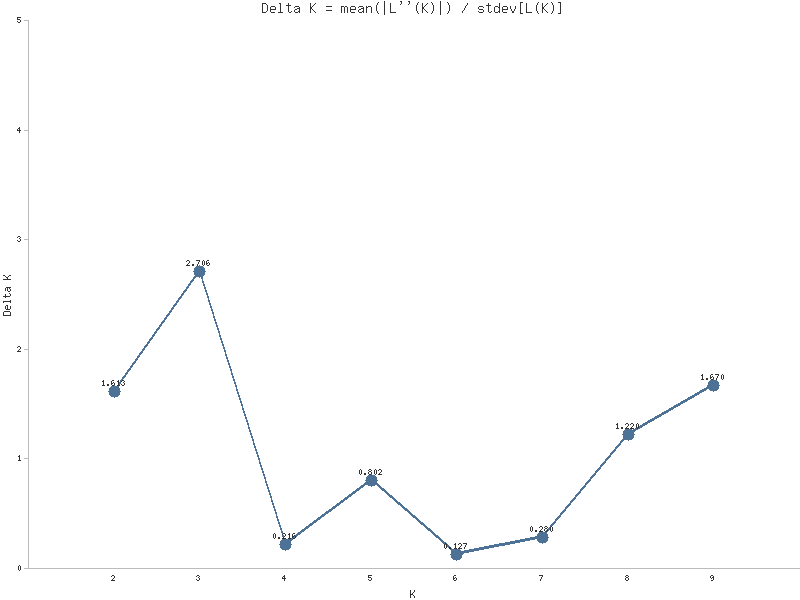

[1] "9"

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Albuquerque_29_5,NAM,Albuquerque,29,5,Rural,Introduced,glue_low1,1,Albuquerque_.29,X1,0.35285
Albuquerque_29_5,NAM,Albuquerque,29,5,Rural,Introduced,glue_low1,1,Albuquerque_.29,X2,0.33820
Albuquerque_29_5,NAM,Albuquerque,29,5,Rural,Introduced,glue_low1,1,Albuquerque_.29,X3,0.30895
Albuquerque_29_9,NAM,Albuquerque,29,9,Rural,Introduced,glue_low1,1,Albuquerque_.29,X1,0.41447
Albuquerque_29_9,NAM,Albuquerque,29,9,Rural,Introduced,glue_low1,1,Albuquerque_.29,X2,0.42888
Albuquerque_29_9,NAM,Albuquerque,29,9,Rural,Introduced,glue_low1,1,Albuquerque_.29,X3,0.15664


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.3334660
Rural,X2,0.3382943
Rural,X3,0.3282398
Urban,X1,0.4370148
Urban,X2,0.2943390
Urban,X3,0.2686460


In [33]:
city <- 'Albuquerque'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Albuquerque_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')
kplot_Albuquerque <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Albuquerque K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Albuquerque_K3.png",
#   plot = kplot_Albuquerque,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Albuquerque_K3.png"
# display_png(file=path_to_kplot)
head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

## Antwerp

[1] "Wed Dec  7 11:09:43 2022: Optimal K by Evanno is: 3"

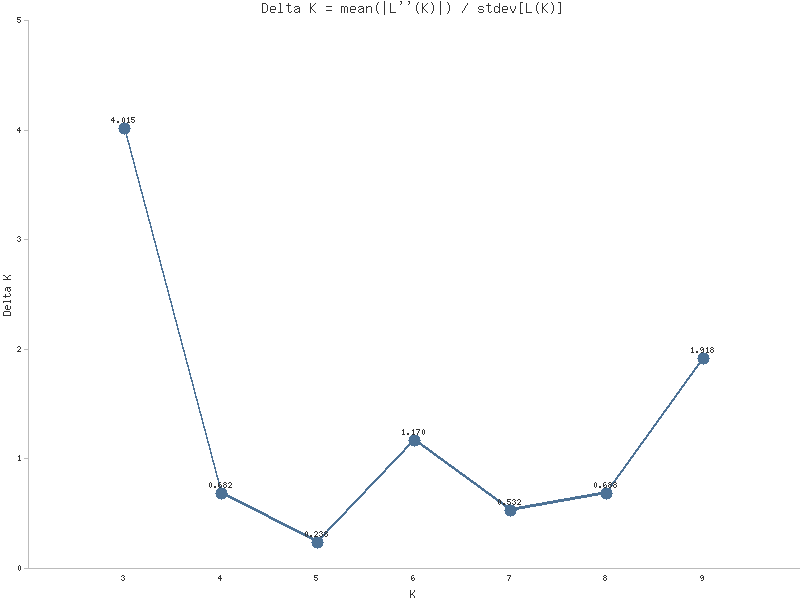

[1] "9"

In [34]:
city <- 'Antwerp'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [35]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Antwerp_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Antwerp <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Anwerp K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Antwerp_K3.png",
#   plot = kplot_Antwerp,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Antwerp_K3.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Antwerp_36_4,EU,Antwerp,36,4,Rural,Native,glue_low1,1,Antwerp_.36,X1,1.00000
Antwerp_36_4,EU,Antwerp,36,4,Rural,Native,glue_low1,1,Antwerp_.36,X2,0.00000
Antwerp_36_4,EU,Antwerp,36,4,Rural,Native,glue_low1,1,Antwerp_.36,X3,0.00000
Antwerp_36_8,EU,Antwerp,36,8,Rural,Native,glue_low1,1,Antwerp_.36,X1,0.00000
Antwerp_36_8,EU,Antwerp,36,8,Rural,Native,glue_low1,1,Antwerp_.36,X2,0.34624
Antwerp_36_8,EU,Antwerp,36,8,Rural,Native,glue_low1,1,Antwerp_.36,X3,0.65376


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.08021222
Rural,X2,0.46778306
Rural,X3,0.45200472
Urban,X1,0.32939098
Urban,X2,0.29641293
Urban,X3,0.37419659


## Armidale

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 2"

[1] "2"

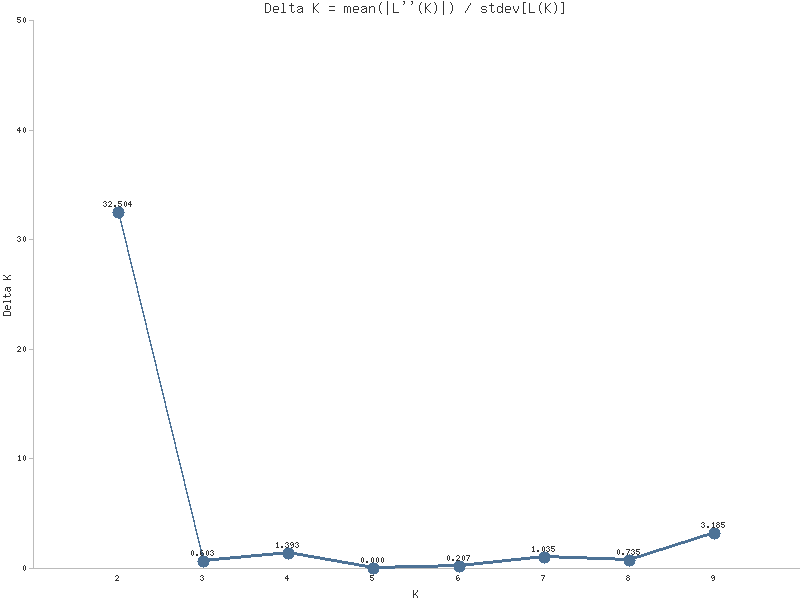

[1] "8"

In [36]:
city <- 'Armidale'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [37]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Armidale_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Armidale <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Armidale K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 


# ggsave(
#   "ADMIX_Armidale_K2.png",
#   plot = kplot_Armidale,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Armidale_K2.png"
# display_png(file=path_to_kplot)


head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Armidale_35_11,OCE,Armidale,35,11,Rural,Introduced,glue_low1,1,Armidale_.35,X1,0.00000
Armidale_35_11,OCE,Armidale,35,11,Rural,Introduced,glue_low1,1,Armidale_.35,X2,1.00000
Armidale_35_16,OCE,Armidale,35,16,Rural,Introduced,glue_low1,1,Armidale_.35,X1,0.00000
Armidale_35_16,OCE,Armidale,35,16,Rural,Introduced,glue_low1,1,Armidale_.35,X2,1.00000
Armidale_36_6,OCE,Armidale,36,6,Rural,Introduced,glue_low1,1,Armidale_.36,X1,0.35745
Armidale_36_6,OCE,Armidale,36,6,Rural,Introduced,glue_low1,1,Armidale_.36,X2,0.64255


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.4985166
Rural,X2,0.5014834
Urban,X1,0.3182518
Urban,X2,0.6817482


## Athens

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 2"

[1] "2"

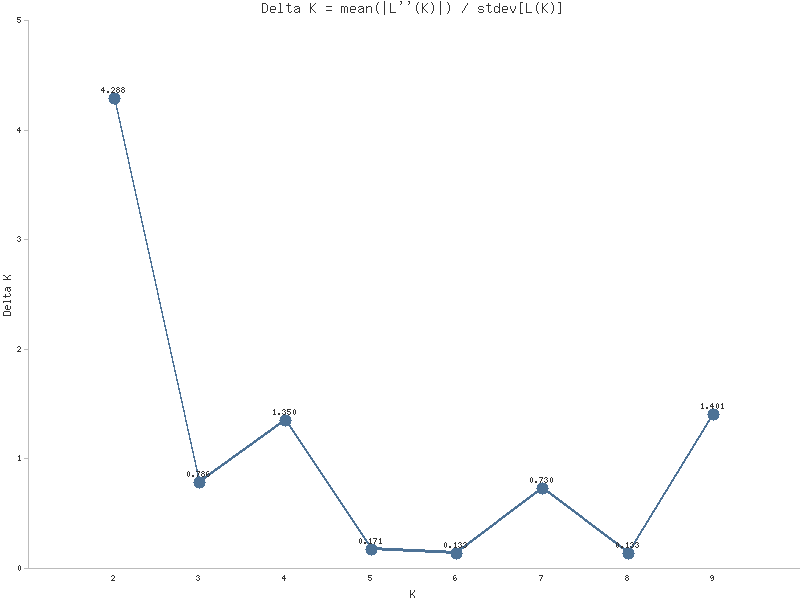

[1] "10"

In [38]:
city <- 'Athens'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [39]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Athens_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Athens <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Athens K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00"))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 


# ggsave(
#   "ADMIX_Athens_K2.png",
#   plot = kplot_Athens,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Athens_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Athens_21_3,NAM,Athens,21,3,Rural,Introduced,glue_low1,1,Athens_.21,X1,0.65894
Athens_21_3,NAM,Athens,21,3,Rural,Introduced,glue_low1,1,Athens_.21,X2,0.34106
Athens_21_18,NAM,Athens,21,18,Rural,Introduced,glue_low1,1,Athens_.21,X1,0.64035
Athens_21_18,NAM,Athens,21,18,Rural,Introduced,glue_low1,1,Athens_.21,X2,0.35965
Athens_22_4,NAM,Athens,22,4,Rural,Introduced,glue_low1,1,Athens_.22,X1,1.00000
Athens_22_4,NAM,Athens,22,4,Rural,Introduced,glue_low1,1,Athens_.22,X2,0.00000


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.5843548
Rural,X2,0.4156453
Urban,X1,0.5326682
Urban,X2,0.4673317


## Buenos_Aires

[1] "Mon Dec  5 21:55:28 2022: Optimal K by Evanno is: 3"

[1] "3"

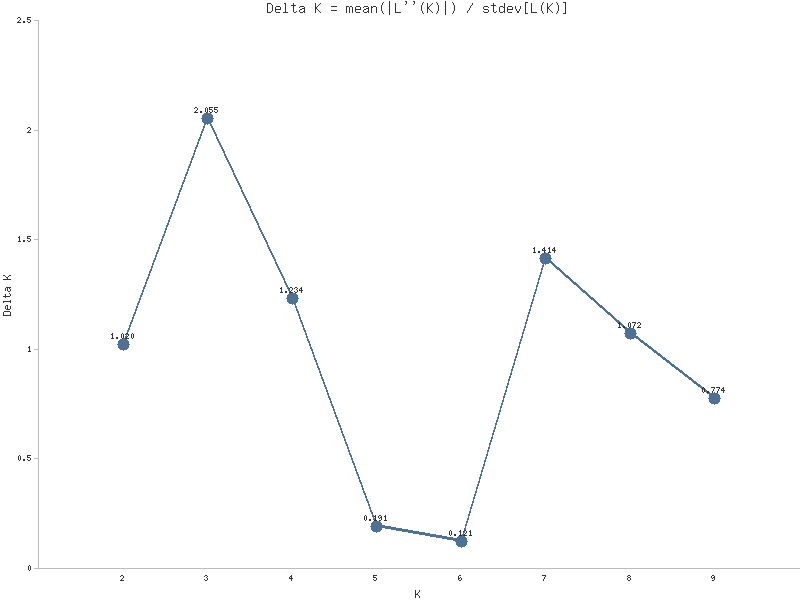

[1] "7"

In [40]:
city <- 'Buenos_Aires'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])

bestSeed

In [41]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Buenos_Aires_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))


kplot_Buenos_Aires <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Buenos Aires K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
  #scale_fill_manual(values = cols_admix) + 
  #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 
  

# ggsave(
#   "ADMIX_Buenos_Aires_K3.png",
#   plot = kplot_Buenos_Aires,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Buenos_Aires_K3.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Buen_Air_1_17,SAM,Buenos_Aires,1,17,Rural,Introduced,glue_low1,1,Buenos_Aires_.1,X1,0.16169
Buen_Air_1_17,SAM,Buenos_Aires,1,17,Rural,Introduced,glue_low1,1,Buenos_Aires_.1,X2,0.33963
Buen_Air_1_17,SAM,Buenos_Aires,1,17,Rural,Introduced,glue_low1,1,Buenos_Aires_.1,X3,0.49868
Buen_Air_1_15,SAM,Buenos_Aires,1,15,Rural,Introduced,glue_low1,1,Buenos_Aires_.1,X1,0.34122
Buen_Air_1_15,SAM,Buenos_Aires,1,15,Rural,Introduced,glue_low1,1,Buenos_Aires_.1,X2,0.65878
Buen_Air_1_15,SAM,Buenos_Aires,1,15,Rural,Introduced,glue_low1,1,Buenos_Aires_.1,X3,0.00000


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.2502226
Rural,X2,0.4588894
Rural,X3,0.2908879
Urban,X1,0.1530050
Urban,X2,0.5104279
Urban,X3,0.3365674


## Calgary

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 2"

[1] "2"

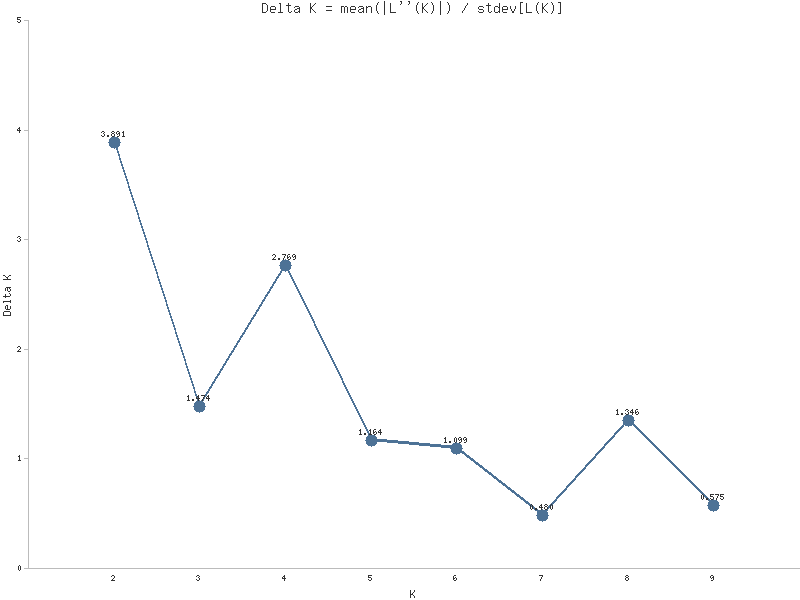

[1] "10"

In [42]:
city <- 'Calgary'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [43]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Calgary_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

cols_admix <- c('#66C2A5','#FC8D62','#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#6A3D9A')

kplot_Calgary <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Calgary K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
  #scale_fill_manual(values = cols_admix) + 
  #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 
  
# ggsave(
#   "ADMIX_Calgary_K2.png",
#   plot = kplot_Calgary,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Calgary_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Calgary_23_1,NAM,Calgary,23,1,Rural,Introduced,glue_low1,1,Calgary_.23,X1,0.64282
Calgary_23_1,NAM,Calgary,23,1,Rural,Introduced,glue_low1,1,Calgary_.23,X2,0.35718
Calgary_23_9,NAM,Calgary,23,9,Rural,Introduced,glue_low1,1,Calgary_.23,X1,0.39761
Calgary_23_9,NAM,Calgary,23,9,Rural,Introduced,glue_low1,1,Calgary_.23,X2,0.60239
Calgary_24_12,NAM,Calgary,24,12,Rural,Introduced,glue_low1,1,Calgary_.24,X1,0.33724
Calgary_24_12,NAM,Calgary,24,12,Rural,Introduced,glue_low1,1,Calgary_.24,X2,0.66276


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.5724760
Rural,X2,0.4275240
Urban,X1,0.3840907
Urban,X2,0.6159093


## Cape_Town

[1] "Wed Dec  7 11:09:43 2022: Optimal K by Evanno is: 4"

[1] "4"

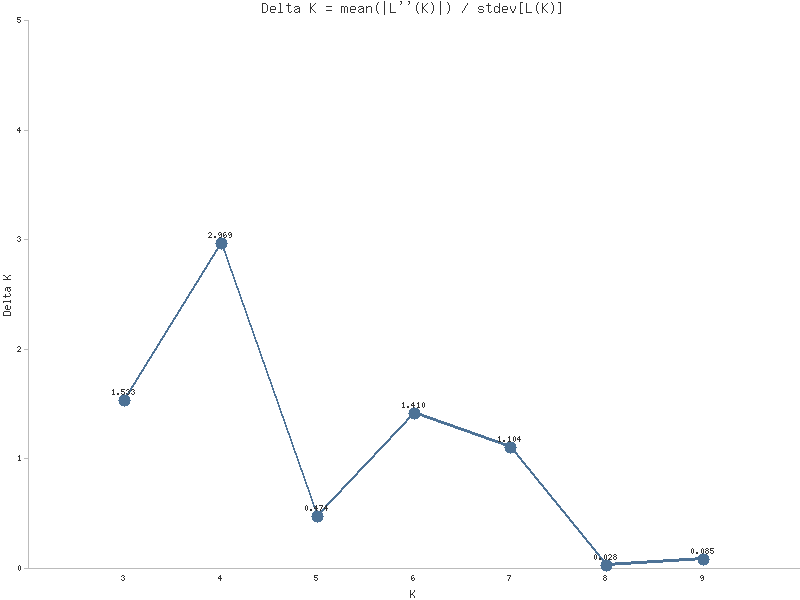

[1] "5"

In [44]:
city <- 'Cape_Town'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [45]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X5) %>%
    bind_cols(., Cape_Town_order_detail) %>% 
    pivot_longer(X1:X4, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))


kplot_Cape_Town <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Cape Town K=4", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 


# ggsave(
#   "ADMIX_Cape_Town_K4.png",
#   plot = kplot_Cape_Town,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Cape_Town_K4.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Cape_Town_7_14,AFR,Cape_Town,7,14,Rural,Introduced,glue_low1,1,Cape_Town_.7,X1,0.00000
Cape_Town_7_14,AFR,Cape_Town,7,14,Rural,Introduced,glue_low1,1,Cape_Town_.7,X2,0.00000
Cape_Town_7_14,AFR,Cape_Town,7,14,Rural,Introduced,glue_low1,1,Cape_Town_.7,X3,0.00000
Cape_Town_7_14,AFR,Cape_Town,7,14,Rural,Introduced,glue_low1,1,Cape_Town_.7,X4,1.00000
Cape_Town_18_3,AFR,Cape_Town,18,3,Rural,Introduced,glue_low1,1,Cape_Town_.18,X1,0.21242
Cape_Town_18_3,AFR,Cape_Town,18,3,Rural,Introduced,glue_low1,1,Cape_Town_.18,X2,0.00000


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.2350037
Rural,X2,0.1509839
Rural,X3,0.2286250
Rural,X4,0.3853871
Urban,X1,0.1639597
Urban,X2,0.3733455
Urban,X3,0.0059345
Urban,X4,0.4567598


## Christchurch

[1] "Mon Nov 28 10:57:31 2022: Optimal K by Evanno is: 4"

[1] "4"

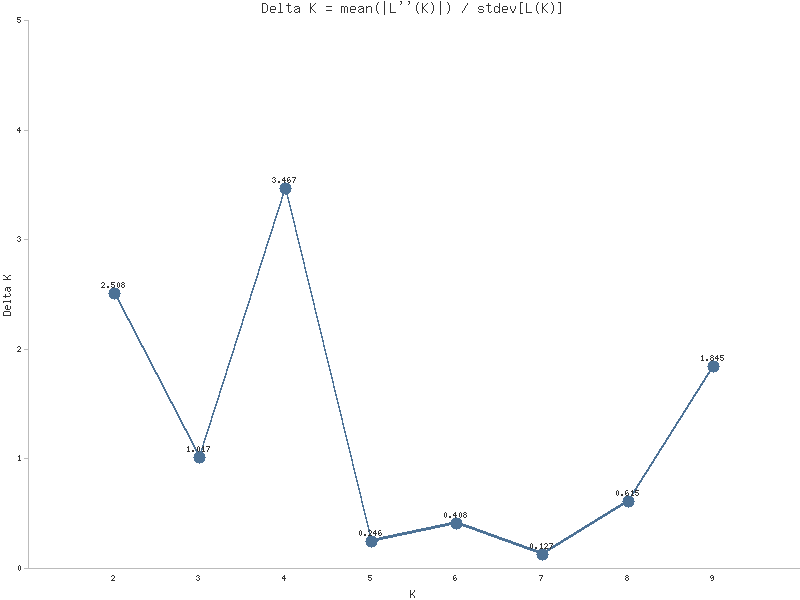

[1] "7"

In [46]:
city <- 'Christchurch'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [47]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X5) %>%
    bind_cols(., Christchurch_order_detail) %>% 
    pivot_longer(X1:X4, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))


cols_admix <- c('#66C2A5','#FC8D62','#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#6A3D9A')

kplot_Christchurch <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Christchurch K=4", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
  #scale_fill_manual(values = cols_admix) + 
  #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 
  
# ggsave(
#   "ADMIX_Christchurch_K4.png",
#   plot = kplot_Christchurch,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Christchurch_K4.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Chrchurch_37_13,OCE,Christchurch,37,13,Rural,Introduced,glue_low1,1,Christchurch_.37,X1,0
Chrchurch_37_13,OCE,Christchurch,37,13,Rural,Introduced,glue_low1,1,Christchurch_.37,X2,0
Chrchurch_37_13,OCE,Christchurch,37,13,Rural,Introduced,glue_low1,1,Christchurch_.37,X3,1
Chrchurch_37_13,OCE,Christchurch,37,13,Rural,Introduced,glue_low1,1,Christchurch_.37,X4,0
Chrchurch_37_2,OCE,Christchurch,37,2,Rural,Introduced,glue_low1,1,Christchurch_.37,X1,1
Chrchurch_37_2,OCE,Christchurch,37,2,Rural,Introduced,glue_low1,1,Christchurch_.37,X2,0


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.4290240
Rural,X2,0.1259669
Rural,X3,0.1443621
Rural,X4,0.3006471
Urban,X1,0.3480862
Urban,X2,0.2375240
Urban,X3,0.1188675
Urban,X4,0.2955225


## Kunming

[1] "Fri Dec  2 16:46:08 2022: Optimal K by Evanno is: 2"

[1] "2"

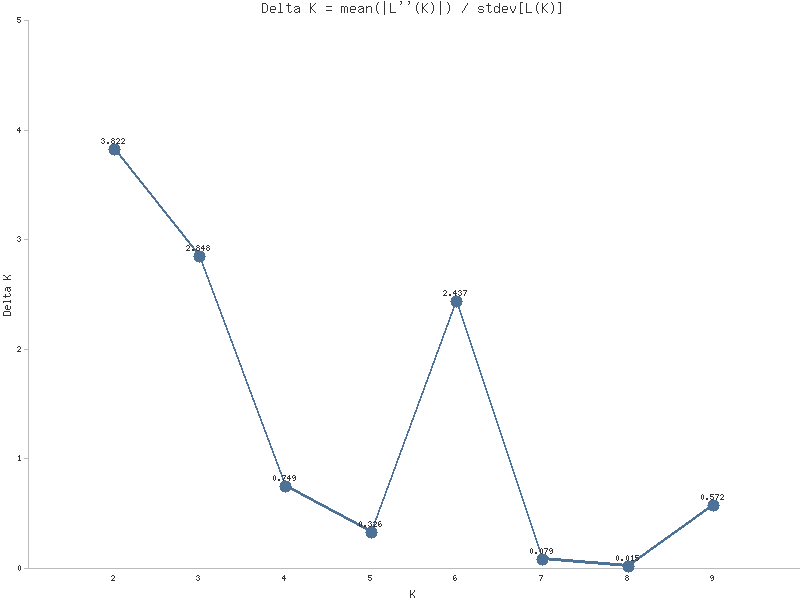

[1] "3"

In [48]:
city <- 'Kunming'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [49]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Kunming_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Kunming <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Kunming K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Kunming_K2.png",
#   plot = kplot_Kunming,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Kunming_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Kunming_46_6,ASI,Kunming,46,6,Rural,Introduced,glue_low1,1,Kunming_.46,X1,0
Kunming_46_6,ASI,Kunming,46,6,Rural,Introduced,glue_low1,1,Kunming_.46,X2,1
Kunming_46_1,ASI,Kunming,46,1,Rural,Introduced,glue_low1,1,Kunming_.46,X1,0
Kunming_46_1,ASI,Kunming,46,1,Rural,Introduced,glue_low1,1,Kunming_.46,X2,1
Kunming_47_7,ASI,Kunming,47,7,Rural,Introduced,glue_low1,1,Kunming_.47,X1,0
Kunming_47_7,ASI,Kunming,47,7,Rural,Introduced,glue_low1,1,Kunming_.47,X2,1


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.6252869
Rural,X2,0.3747131
Urban,X1,0.5180776
Urban,X2,0.4819224


## Landshut

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 2"

[1] "2"

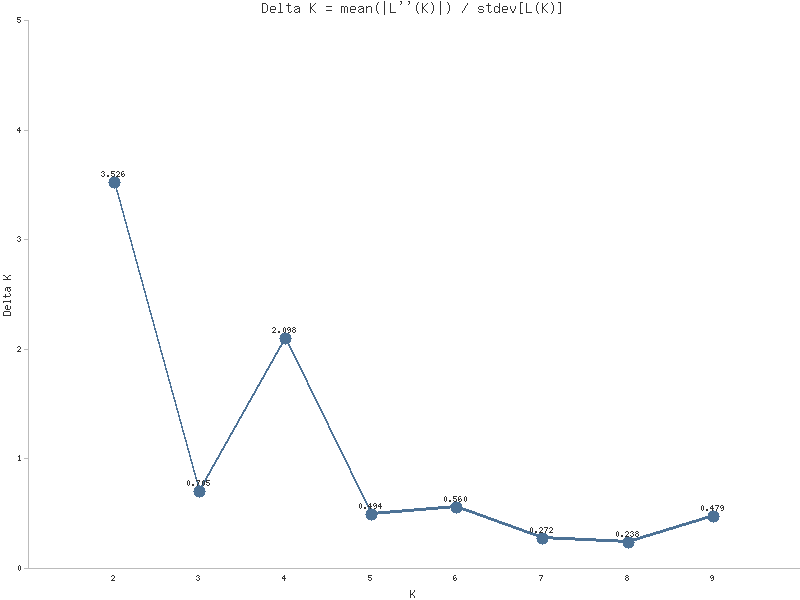

[1] "1"

In [50]:
city <- 'Landshut'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [51]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Landshut_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Landshut <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Landshut K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 


# ggsave(
#   "ADMIX_Landshut_K2.png",
#   plot = kplot_Landshut,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Landshut_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Landshut_1_1,EU,Landshut,1,1,Rural,Native,glue_low1,1,Landshut_.1,X1,0.54476
Landshut_1_1,EU,Landshut,1,1,Rural,Native,glue_low1,1,Landshut_.1,X2,0.45524
Landshut_1_18,EU,Landshut,1,18,Rural,Native,glue_low1,1,Landshut_.1,X1,0.00000
Landshut_1_18,EU,Landshut,1,18,Rural,Native,glue_low1,1,Landshut_.1,X2,1.00000
Landshut_2_8,EU,Landshut,2,8,Rural,Native,glue_low1,1,Landshut_.2,X1,0.66801
Landshut_2_8,EU,Landshut,2,8,Rural,Native,glue_low1,1,Landshut_.2,X2,0.33199


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.6008504
Rural,X2,0.3991496
Urban,X1,0.4276291
Urban,X2,0.5723709


## Linkoping

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 2"

[1] "2"

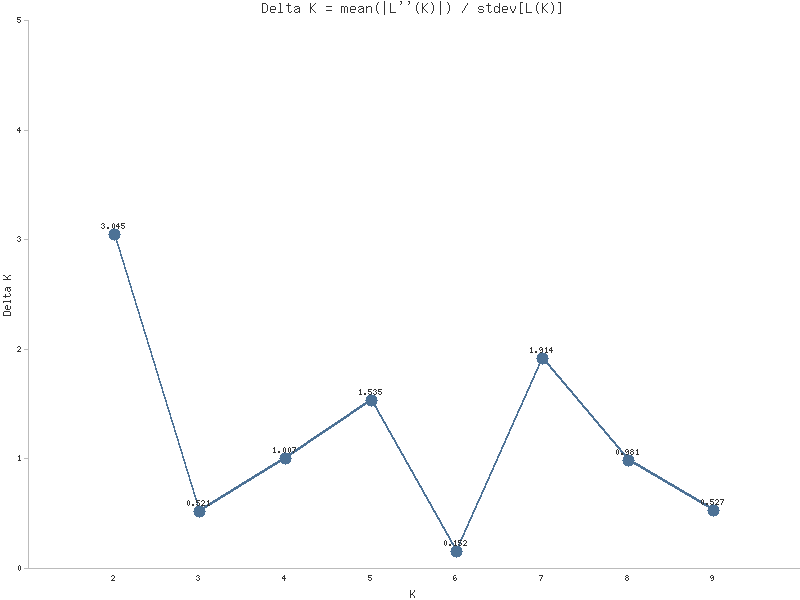

[1] "6"

In [52]:
city <- 'Linkoping'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [53]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Linkoping_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Linkoping <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Linkoping K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Linkoping_K2.png",
#   plot = kplot_Linkoping,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Linkoping_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Linkoping_25_9,EU,Linkoping,25,9,Rural,Native,glue_low1,1,Linkoping_.25,X1,0.6581
Linkoping_25_9,EU,Linkoping,25,9,Rural,Native,glue_low1,1,Linkoping_.25,X2,0.3419
Linkoping_25_7,EU,Linkoping,25,7,Rural,Native,glue_low1,1,Linkoping_.25,X1,0.0000
Linkoping_25_7,EU,Linkoping,25,7,Rural,Native,glue_low1,1,Linkoping_.25,X2,1.0000
Linkoping_27_8,EU,Linkoping,27,8,Rural,Native,glue_low1,1,Linkoping_.27,X1,0.0000
Linkoping_27_8,EU,Linkoping,27,8,Rural,Native,glue_low1,1,Linkoping_.27,X2,1.0000


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.6211831
Rural,X2,0.3788169
Urban,X1,0.5786195
Urban,X2,0.4213805


## Loja

[1] "Tue Dec  6 17:12:05 2022: Optimal K by Evanno is: 3"

[1] "3"

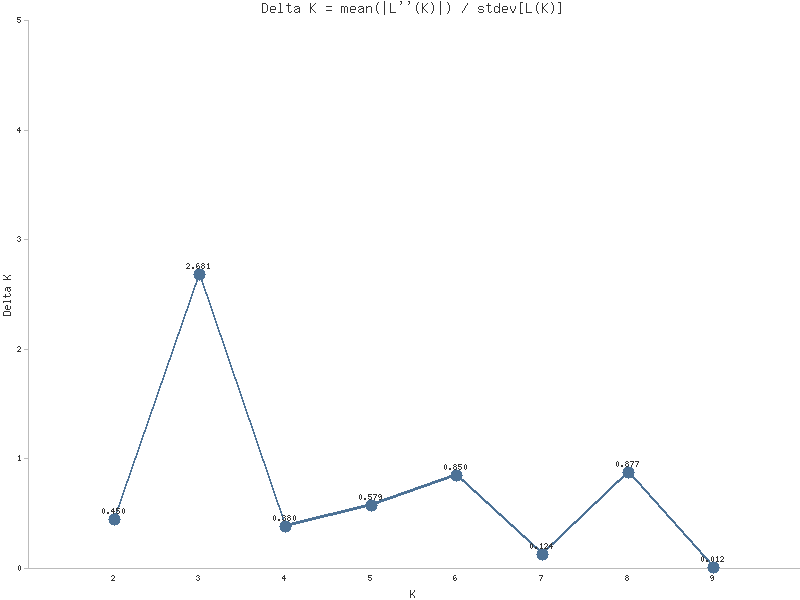

[1] "5"

In [54]:
city <- 'Loja'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [55]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Loja_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Loja <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Loja K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Loja_K3.png",
#   plot = kplot_Loja,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Loja_K3.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Loja_1_19,SAM,Loja,1,19,Rural,Introduced,glue_low1,1,Loja_.1,X1,0.00000
Loja_1_19,SAM,Loja,1,19,Rural,Introduced,glue_low1,1,Loja_.1,X2,0.00000
Loja_1_19,SAM,Loja,1,19,Rural,Introduced,glue_low1,1,Loja_.1,X3,1.00000
Loja_1_7,SAM,Loja,1,7,Rural,Introduced,glue_low1,1,Loja_.1,X1,0.10115
Loja_1_7,SAM,Loja,1,7,Rural,Introduced,glue_low1,1,Loja_.1,X2,0.22061
Loja_1_7,SAM,Loja,1,7,Rural,Introduced,glue_low1,1,Loja_.1,X3,0.67824


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.2142246
Rural,X2,0.2403292
Rural,X3,0.5454458
Urban,X1,0.1127024
Urban,X2,0.1957834
Urban,X3,0.6915141


## Memphis

[1] "Wed Dec  7 11:09:43 2022: Optimal K by Evanno is: 3"

[1] "3"

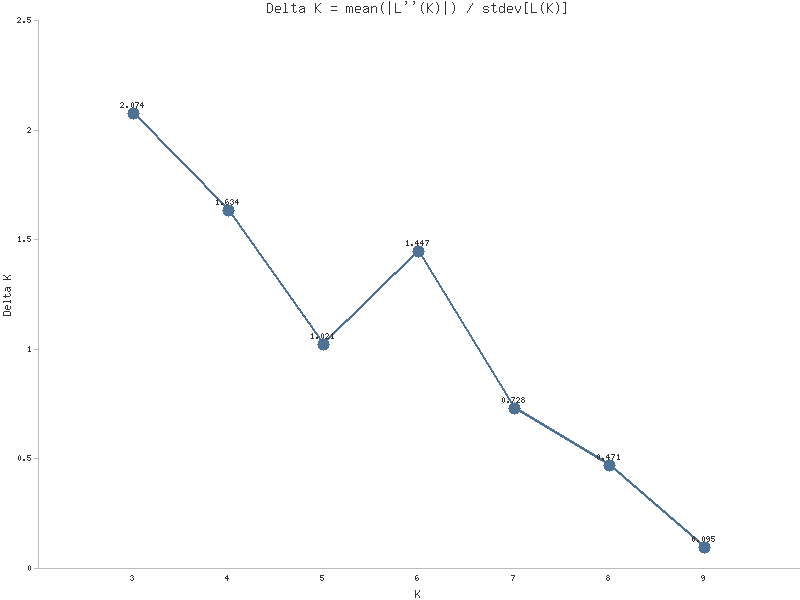

[1] "10"

In [56]:
city <- 'Memphis'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [57]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Memphis_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Memphis <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Memphis K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Memphis_K3.png",
#   plot = kplot_Memphis,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Memphis_K3.png"
# display_png(file=path_to_kplot)
head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Memphis_45_12,NAM,Memphis,45,12,Rural,Introduced,glue_low1,1,Memphis_.45,X1,0
Memphis_45_12,NAM,Memphis,45,12,Rural,Introduced,glue_low1,1,Memphis_.45,X2,0
Memphis_45_12,NAM,Memphis,45,12,Rural,Introduced,glue_low1,1,Memphis_.45,X3,1
Memphis_47_1,NAM,Memphis,47,1,Rural,Introduced,glue_low1,1,Memphis_.47,X1,0
Memphis_47_1,NAM,Memphis,47,1,Rural,Introduced,glue_low1,1,Memphis_.47,X2,1
Memphis_47_1,NAM,Memphis,47,1,Rural,Introduced,glue_low1,1,Memphis_.47,X3,0


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.1647868
Rural,X2,0.5023432
Rural,X3,0.3328695
Urban,X1,0.4808216
Urban,X2,0.2675023
Urban,X3,0.2516757


## Mexico_City

[1] "Fri Dec  2 16:46:04 2022: Optimal K by Evanno is: 2"

[1] "2"

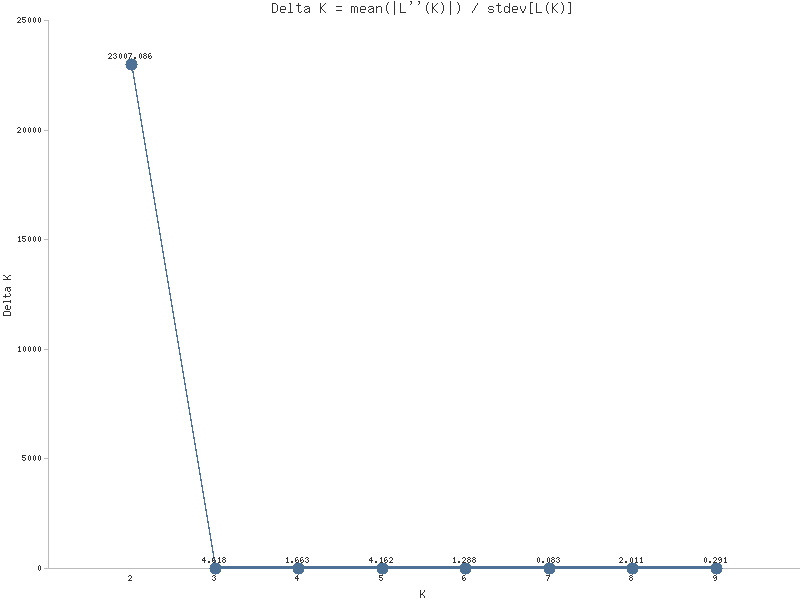

[1] "2"

In [58]:
city <- 'Mexico_City'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [59]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Mexico_City_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Mexico_City <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Mexico City K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Mexico_City_K2.png",
#   plot = kplot_Mexico_City,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Mexico_City_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Mexico_City_18_9,NAM,Mexico_City,18,9,Rural,Introduced,glue_low1,1,Mexico_City_.18,X1,1.00000
Mexico_City_18_9,NAM,Mexico_City,18,9,Rural,Introduced,glue_low1,1,Mexico_City_.18,X2,0.00000
Mexico_City_18_5,NAM,Mexico_City,18,5,Rural,Introduced,glue_low1,1,Mexico_City_.18,X1,0.00000
Mexico_City_18_5,NAM,Mexico_City,18,5,Rural,Introduced,glue_low1,1,Mexico_City_.18,X2,1.00000
Mexico_City_20_12,NAM,Mexico_City,20,12,Rural,Introduced,glue_low1,1,Mexico_City_.20,X1,0.00062
Mexico_City_20_12,NAM,Mexico_City,20,12,Rural,Introduced,glue_low1,1,Mexico_City_.20,X2,0.99938


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.0624960
Rural,X2,0.9375040
Urban,X1,0.1950782
Urban,X2,0.8049218


## Munich

[1] "Fri Dec  2 16:46:03 2022: Optimal K by Evanno is: 2"

[1] "2"

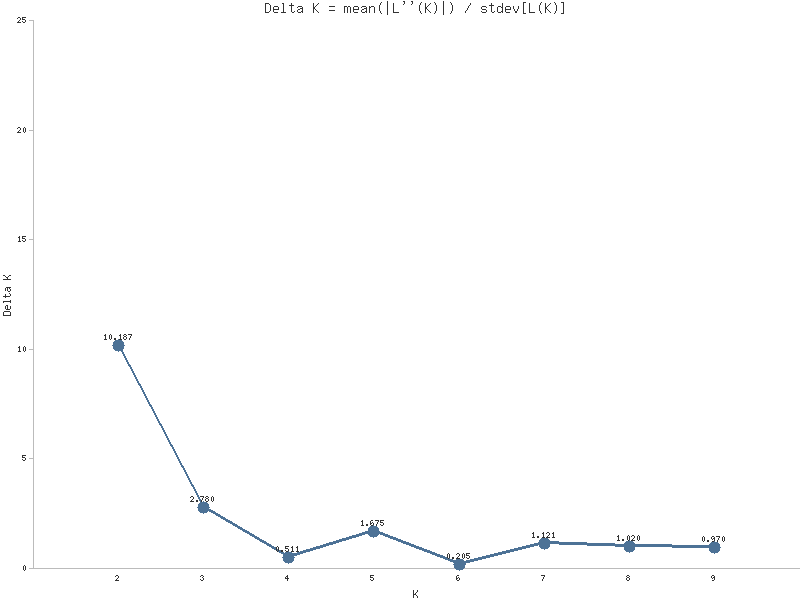

[1] "1"

In [60]:
city <- 'Munich'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [61]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Munich_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Munich <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Munich K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 
  
# ggsave(
#   "ADMIX_Munich_K2.png",
#   plot = kplot_Munich,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Munich_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Munich_1_5,EU,Munich,1,5,Rural,Native,glue_low1,1,Munich_.1,X1,1
Munich_1_5,EU,Munich,1,5,Rural,Native,glue_low1,1,Munich_.1,X2,0
Munich_1_4,EU,Munich,1,4,Rural,Native,glue_low1,1,Munich_.1,X1,1
Munich_1_4,EU,Munich,1,4,Rural,Native,glue_low1,1,Munich_.1,X2,0
Munich_2_9,EU,Munich,2,9,Rural,Native,glue_low1,1,Munich_.2,X1,1
Munich_2_9,EU,Munich,2,9,Rural,Native,glue_low1,1,Munich_.2,X2,0


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.4295542
Rural,X2,0.5704458
Urban,X1,0.7840452
Urban,X2,0.2159548


## Palmerston_North

[1] "Tue Dec  6 00:39:22 2022: Optimal K by Evanno is: 3"

[1] "3"

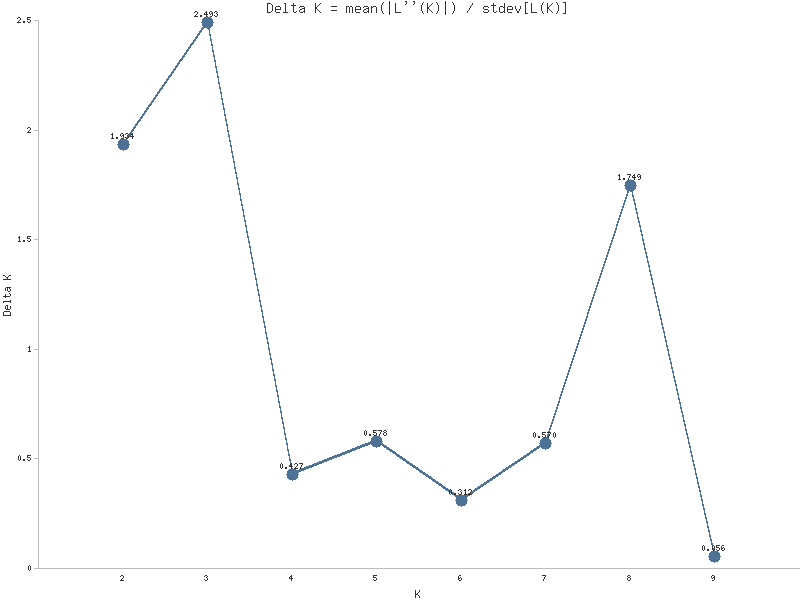

[1] "10"

In [62]:
city <- 'Palmerston_North'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [63]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Palmerston_North_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))
admix<-admix[order(admix$site),]
#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Palmerston_North <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Palmerston North K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Palmerston_North_K3.png",
#   plot = kplot_Palmerston_North,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Palmerston_North_K3.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Palm_North_36_3,OCE,Palmerston_North,36,3,Rural,Introduced,deep3,2,Palmerston_North_.36,X1,0.26798
Palm_North_36_3,OCE,Palmerston_North,36,3,Rural,Introduced,deep3,2,Palmerston_North_.36,X2,0.34727
Palm_North_36_3,OCE,Palmerston_North,36,3,Rural,Introduced,deep3,2,Palmerston_North_.36,X3,0.38475
Palm_North_36_4,OCE,Palmerston_North,36,4,Rural,Introduced,deep3,2,Palmerston_North_.36,X1,0.39079
Palm_North_36_4,OCE,Palmerston_North,36,4,Rural,Introduced,deep3,2,Palmerston_North_.36,X2,0.19539
Palm_North_36_4,OCE,Palmerston_North,36,4,Rural,Introduced,deep3,2,Palmerston_North_.36,X3,0.41382


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.1993876
Rural,X2,0.4264735
Rural,X3,0.3741388
Urban,X1,0.4271274
Urban,X2,0.2390202
Urban,X3,0.3338523


## Punta Arenas

[1] "Fri Dec  2 18:34:07 2022: Optimal K by Evanno is: 2"

[1] "2"

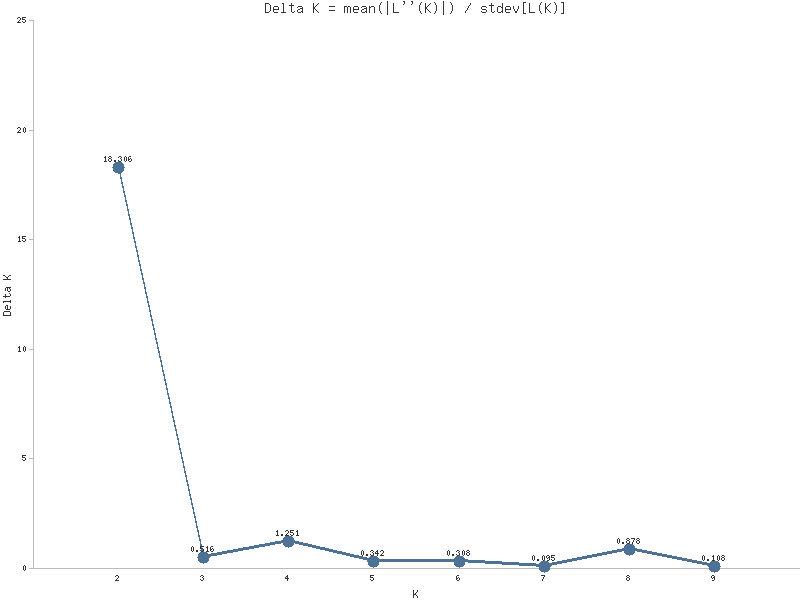

[1] "4"

In [64]:
city <- 'Punta_Arenas'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [65]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Punta_Arenas_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))
admix<-admix[order(admix$site),]
kplot_Punta_Arenas <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Punta Arenas K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Punta_Arenas_K2.png",
#   plot = kplot_Punta_Arenas,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Punta_Arenas_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Punt_Ar_20_2,SAM,Punta_Arenas,20,2,Rural,Introduced,deep3,3,Punta_Arenas_.20,X1,0
Punt_Ar_20_2,SAM,Punta_Arenas,20,2,Rural,Introduced,deep3,3,Punta_Arenas_.20,X2,1
Punt_Ar_20_3,SAM,Punta_Arenas,20,3,Rural,Introduced,deep3,3,Punta_Arenas_.20,X1,1
Punt_Ar_20_3,SAM,Punta_Arenas,20,3,Rural,Introduced,deep3,3,Punta_Arenas_.20,X2,0
Punt_Ar_20_6,SAM,Punta_Arenas,20,6,Rural,Introduced,deep3,3,Punta_Arenas_.20,X1,1
Punt_Ar_20_6,SAM,Punta_Arenas,20,6,Rural,Introduced,deep3,3,Punta_Arenas_.20,X2,0


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.4984641
Rural,X2,0.5015359
Urban,X1,0.8715797
Urban,X2,0.1284203


## Quito

[1] "Tue Dec  6 14:09:14 2022: Optimal K by Evanno is: 5"

[1] "5"

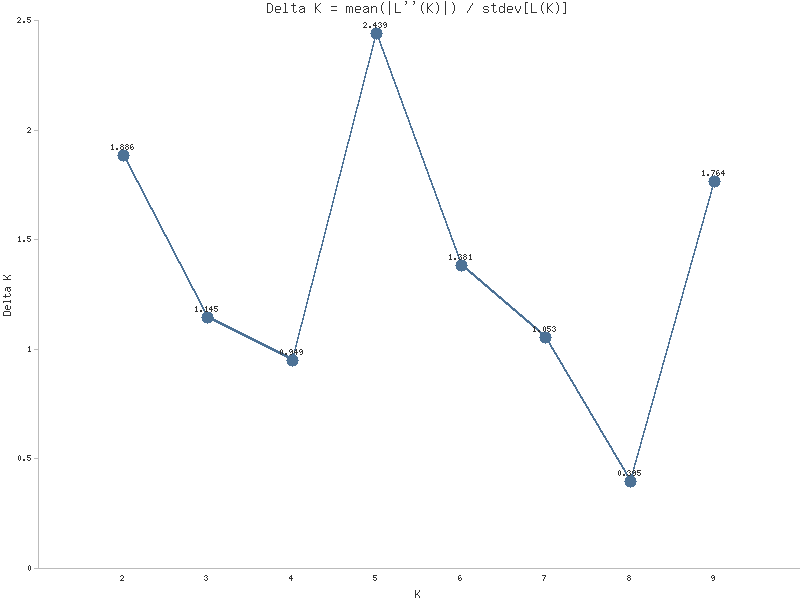

[1] "8"

In [66]:
city <- 'Quito'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [67]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X6) %>%
    bind_cols(., Quito_order_detail) %>% 
    pivot_longer(X1:X5, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Quito <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Quito K=5", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Quito_K5.png",
#   plot = kplot_Quito,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Quito_K5.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Quito_1_12,SAM,Quito,1,12,Rural,Introduced,glue_low1,1,Quito_.1,X1,1
Quito_1_12,SAM,Quito,1,12,Rural,Introduced,glue_low1,1,Quito_.1,X2,0
Quito_1_12,SAM,Quito,1,12,Rural,Introduced,glue_low1,1,Quito_.1,X3,0
Quito_1_12,SAM,Quito,1,12,Rural,Introduced,glue_low1,1,Quito_.1,X4,0
Quito_1_12,SAM,Quito,1,12,Rural,Introduced,glue_low1,1,Quito_.1,X5,0
Quito_1_18,SAM,Quito,1,18,Rural,Introduced,glue_low1,1,Quito_.1,X1,1


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.4471752
Rural,X2,0.1029638
Rural,X3,0.1047943
Rural,X4,0.1950019
Rural,X5,0.1500648
Urban,X1,0.3465063
Urban,X2,0.1875000
Urban,X3,0.2500000
Urban,X4,0.0000000


## Sapporo

[1] "Tue Dec  6 12:38:19 2022: Optimal K by Evanno is: 2"

[1] "2"

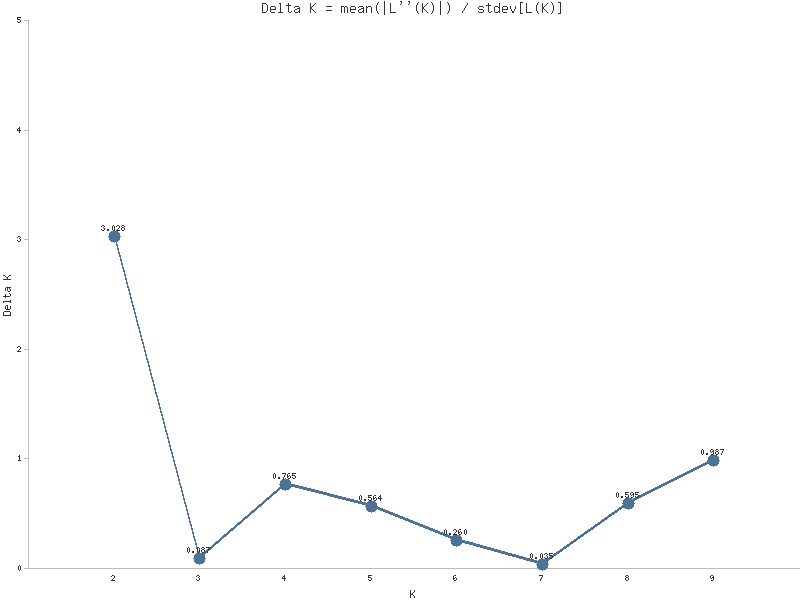

[1] "5"

In [68]:
city <- 'Sapporo'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed

In [69]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Sapporo_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))
admix<-admix[order(admix$site),]
kplot_Sapporo <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Sapporo K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Sapporo_K2.png",
#   plot = kplot_Sapporo,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Sapporo_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Sapporo_40_4,ASI,Sapporo,40,4,Rural,Introduced,deep3,3,Sapporo_.40,X1,1.00000
Sapporo_40_4,ASI,Sapporo,40,4,Rural,Introduced,deep3,3,Sapporo_.40,X2,0.00000
Sapporo_40_13,ASI,Sapporo,40,13,Rural,Introduced,deep3,3,Sapporo_.40,X1,0.60554
Sapporo_40_13,ASI,Sapporo,40,13,Rural,Introduced,deep3,3,Sapporo_.40,X2,0.39446
Sapporo_40_14,ASI,Sapporo,40,14,Rural,Introduced,deep3,3,Sapporo_.40,X1,0.56151
Sapporo_40_14,ASI,Sapporo,40,14,Rural,Introduced,deep3,3,Sapporo_.40,X2,0.43849


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.5801121
Rural,X2,0.4198879
Urban,X1,0.4950293
Urban,X2,0.5049707


## Tehran

[1] "Tue Dec  6 17:12:02 2022: Optimal K by Evanno is: 2"

[1] "2"

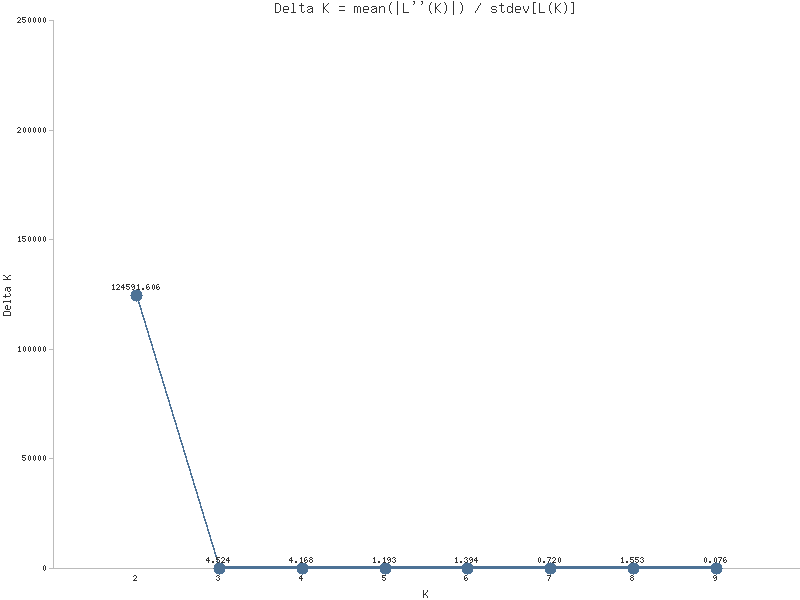

[1] "5"

In [70]:
city <- 'Tehran'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [71]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Tehran_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))


kplot_Tehran <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Tehran K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Tehran_K2.png",
#   plot = kplot_Tehran,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Tehran_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Tehran_27_10,ASI,Tehran,27,10,Rural,Native,glue_low1,1,Tehran_.27,X1,0
Tehran_27_10,ASI,Tehran,27,10,Rural,Native,glue_low1,1,Tehran_.27,X2,1
Tehran_27_2,ASI,Tehran,27,2,Rural,Native,glue_low1,1,Tehran_.27,X1,0
Tehran_27_2,ASI,Tehran,27,2,Rural,Native,glue_low1,1,Tehran_.27,X2,1
Tehran_28_6,ASI,Tehran,28,6,Rural,Native,glue_low1,1,Tehran_.28,X1,1
Tehran_28_6,ASI,Tehran,28,6,Rural,Native,glue_low1,1,Tehran_.28,X2,0


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.6920832
Rural,X2,0.3079168
Urban,X1,0.6498856
Urban,X2,0.3501144


## Thessaloniki

[1] "Mon Dec  5 23:09:15 2022: Optimal K by Evanno is: 2"

[1] "2"

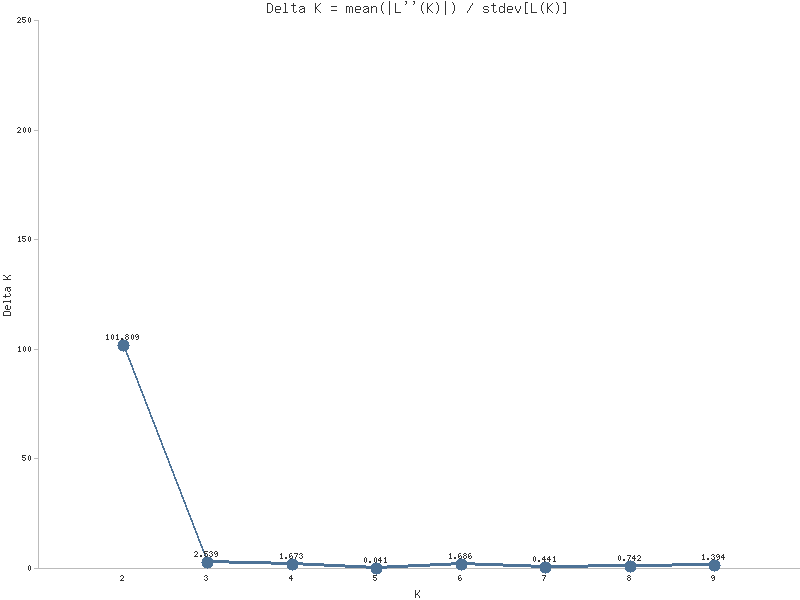

[1] "2"

In [72]:
city <- 'Thessaloniki'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [73]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Thessaloniki_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Thessaloniki <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Thessaloniki K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Thessaloniki_K2.png",
#   plot = kplot_Thessaloniki,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Thessaloniki_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Thessa_42_4,EU,Thessaloniki,42,4,Rural,Native,glue_low1,1,Thessaloniki_.42,X1,1
Thessa_42_4,EU,Thessaloniki,42,4,Rural,Native,glue_low1,1,Thessaloniki_.42,X2,0
Thessa_42_19,EU,Thessaloniki,42,19,Rural,Native,glue_low1,1,Thessaloniki_.42,X1,1
Thessa_42_19,EU,Thessaloniki,42,19,Rural,Native,glue_low1,1,Thessaloniki_.42,X2,0
Thessa_43_10,EU,Thessaloniki,43,10,Rural,Native,glue_low1,1,Thessaloniki_.43,X1,1
Thessa_43_10,EU,Thessaloniki,43,10,Rural,Native,glue_low1,1,Thessaloniki_.43,X2,0


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.1955465
Rural,X2,0.8044535
Urban,X1,0.4702528
Urban,X2,0.5297472


## Toronto

[1] "Wed Dec  7 11:09:43 2022: Optimal K by Evanno is: 3"

[1] "3"

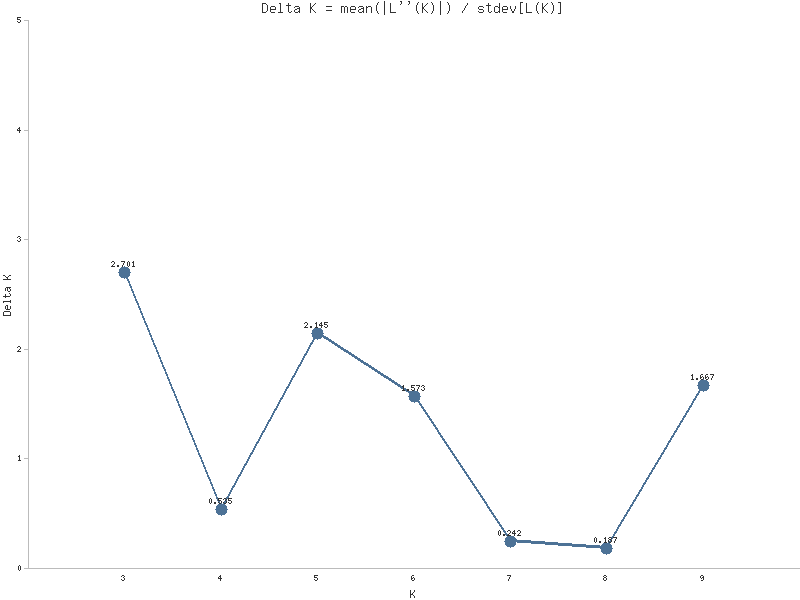

[1] "2"

In [74]:
city <- 'Toronto'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed


In [75]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Toronto_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))
admix<-admix[order(admix$site),]
#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Toronto <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Toronto K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Toronto_K3.png",
#   plot = kplot_Toronto,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Toronto_K3.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
s_1_9,NAM,Toronto,1,9,Rural,Introduced,Toronto,1,Toronto_.1,X1,0.22571
s_1_9,NAM,Toronto,1,9,Rural,Introduced,Toronto,1,Toronto_.1,X2,0.52620
s_1_9,NAM,Toronto,1,9,Rural,Introduced,Toronto,1,Toronto_.1,X3,0.24810
s_2_3,NAM,Toronto,2,3,Rural,Introduced,Toronto,1,Toronto_.2,X1,0.14048
s_2_3,NAM,Toronto,2,3,Rural,Introduced,Toronto,1,Toronto_.2,X2,0.71310
s_2_3,NAM,Toronto,2,3,Rural,Introduced,Toronto,1,Toronto_.2,X3,0.14642


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.1525271
Rural,X2,0.4887210
Rural,X3,0.3587522
Urban,X1,0.3225239
Urban,X2,0.5820795
Urban,X3,0.0953961


## Vancouver

[1] "Sun Dec  4 18:42:26 2022: Optimal K by Evanno is: 2"

[1] "2"

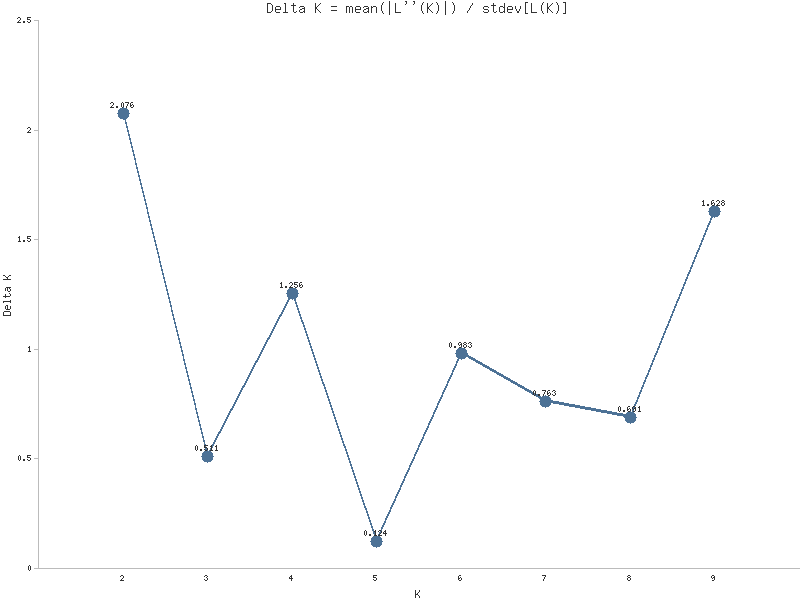

[1] "5"

In [76]:
city <- 'Vancouver'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed

In [77]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Vancouver_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))
admix<-admix[order(admix$site),]

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Vancouver <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Vancouver K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Vancouver_K2.png",
#   plot = kplot_Vancouver,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Vancouver_K2.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Vancouver_36_1,NAM,Vancouver,36,1,Rural,Introduced,deep3,3,Vancouver_.36,X1,1.00000
Vancouver_36_1,NAM,Vancouver,36,1,Rural,Introduced,deep3,3,Vancouver_.36,X2,0.00000
Vancouver_36_3,NAM,Vancouver,36,3,Rural,Introduced,deep3,3,Vancouver_.36,X1,0.59564
Vancouver_36_3,NAM,Vancouver,36,3,Rural,Introduced,deep3,3,Vancouver_.36,X2,0.40436
Vancouver_36_4,NAM,Vancouver,36,4,Rural,Introduced,deep3,3,Vancouver_.36,X1,0.61394
Vancouver_36_4,NAM,Vancouver,36,4,Rural,Introduced,deep3,3,Vancouver_.36,X2,0.38606


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.5196690
Rural,X2,0.4803310
Urban,X1,0.6684957
Urban,X2,0.3315043


In [78]:
## Warsaw

[1] "Mon Nov 28 10:57:33 2022: Optimal K by Evanno is: 6"

[1] "6"

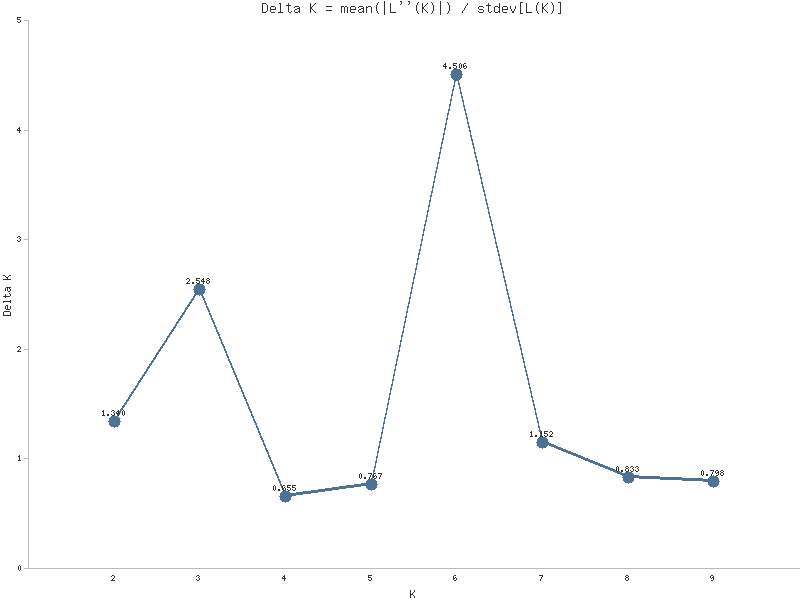

[1] "1"

In [79]:
city <- 'Warsaw'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])
bestSeed

In [80]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X7) %>%
    bind_cols(., Warsaw_order_detail) %>% 
    pivot_longer(X1:X6, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))
#admix$site <- factor(admix$site, levels=c("Rural", "Urban"))
admix<-admix[order(admix$site),]
cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')


kplot_Warsaw <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Warsaw K=6", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_manual(values=c("#F0E442", "#0072B2","#CC79A7","#E69F00", "#56B4E9", "#009E73", "#D55E00" ))+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

# ggsave(
#   "ADMIX_Warsaw_K6.png",
#   plot = kplot_Warsaw,
#   device = png,
#   path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
#   width = 14,
#   height = 5,
#   units = "cm",
#   dpi = 300
# )

# path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Warsaw_K6.png"
# display_png(file=path_to_kplot)

head(admix)
df <- admix %>% 
    group_by(site, name) %>%
    summarise(prob_mean = mean(Probs),
                .groups = 'drop')
df

sample,continent,city,pop,individual,site,range,library,lane,city_pop,name,Probs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
Warsaw_46_5,EU,Warsaw,46,5,Rural,Native,deep3,3,Warsaw_.46,X1,1
Warsaw_46_5,EU,Warsaw,46,5,Rural,Native,deep3,3,Warsaw_.46,X2,0
Warsaw_46_5,EU,Warsaw,46,5,Rural,Native,deep3,3,Warsaw_.46,X3,0
Warsaw_46_5,EU,Warsaw,46,5,Rural,Native,deep3,3,Warsaw_.46,X4,0
Warsaw_46_5,EU,Warsaw,46,5,Rural,Native,deep3,3,Warsaw_.46,X5,0
Warsaw_46_5,EU,Warsaw,46,5,Rural,Native,deep3,3,Warsaw_.46,X6,0


site,name,prob_mean
<chr>,<chr>,<dbl>
Rural,X1,0.29817935
Rural,X2,0.20731645
Rural,X3,0.15774258
Rural,X4,0.15499161
Rural,X5,0.11371323
Rural,X6,0.06805645
Urban,X1,0.15619333
Urban,X2,0.12672487
Urban,X3,0.21943154


## Combine plots

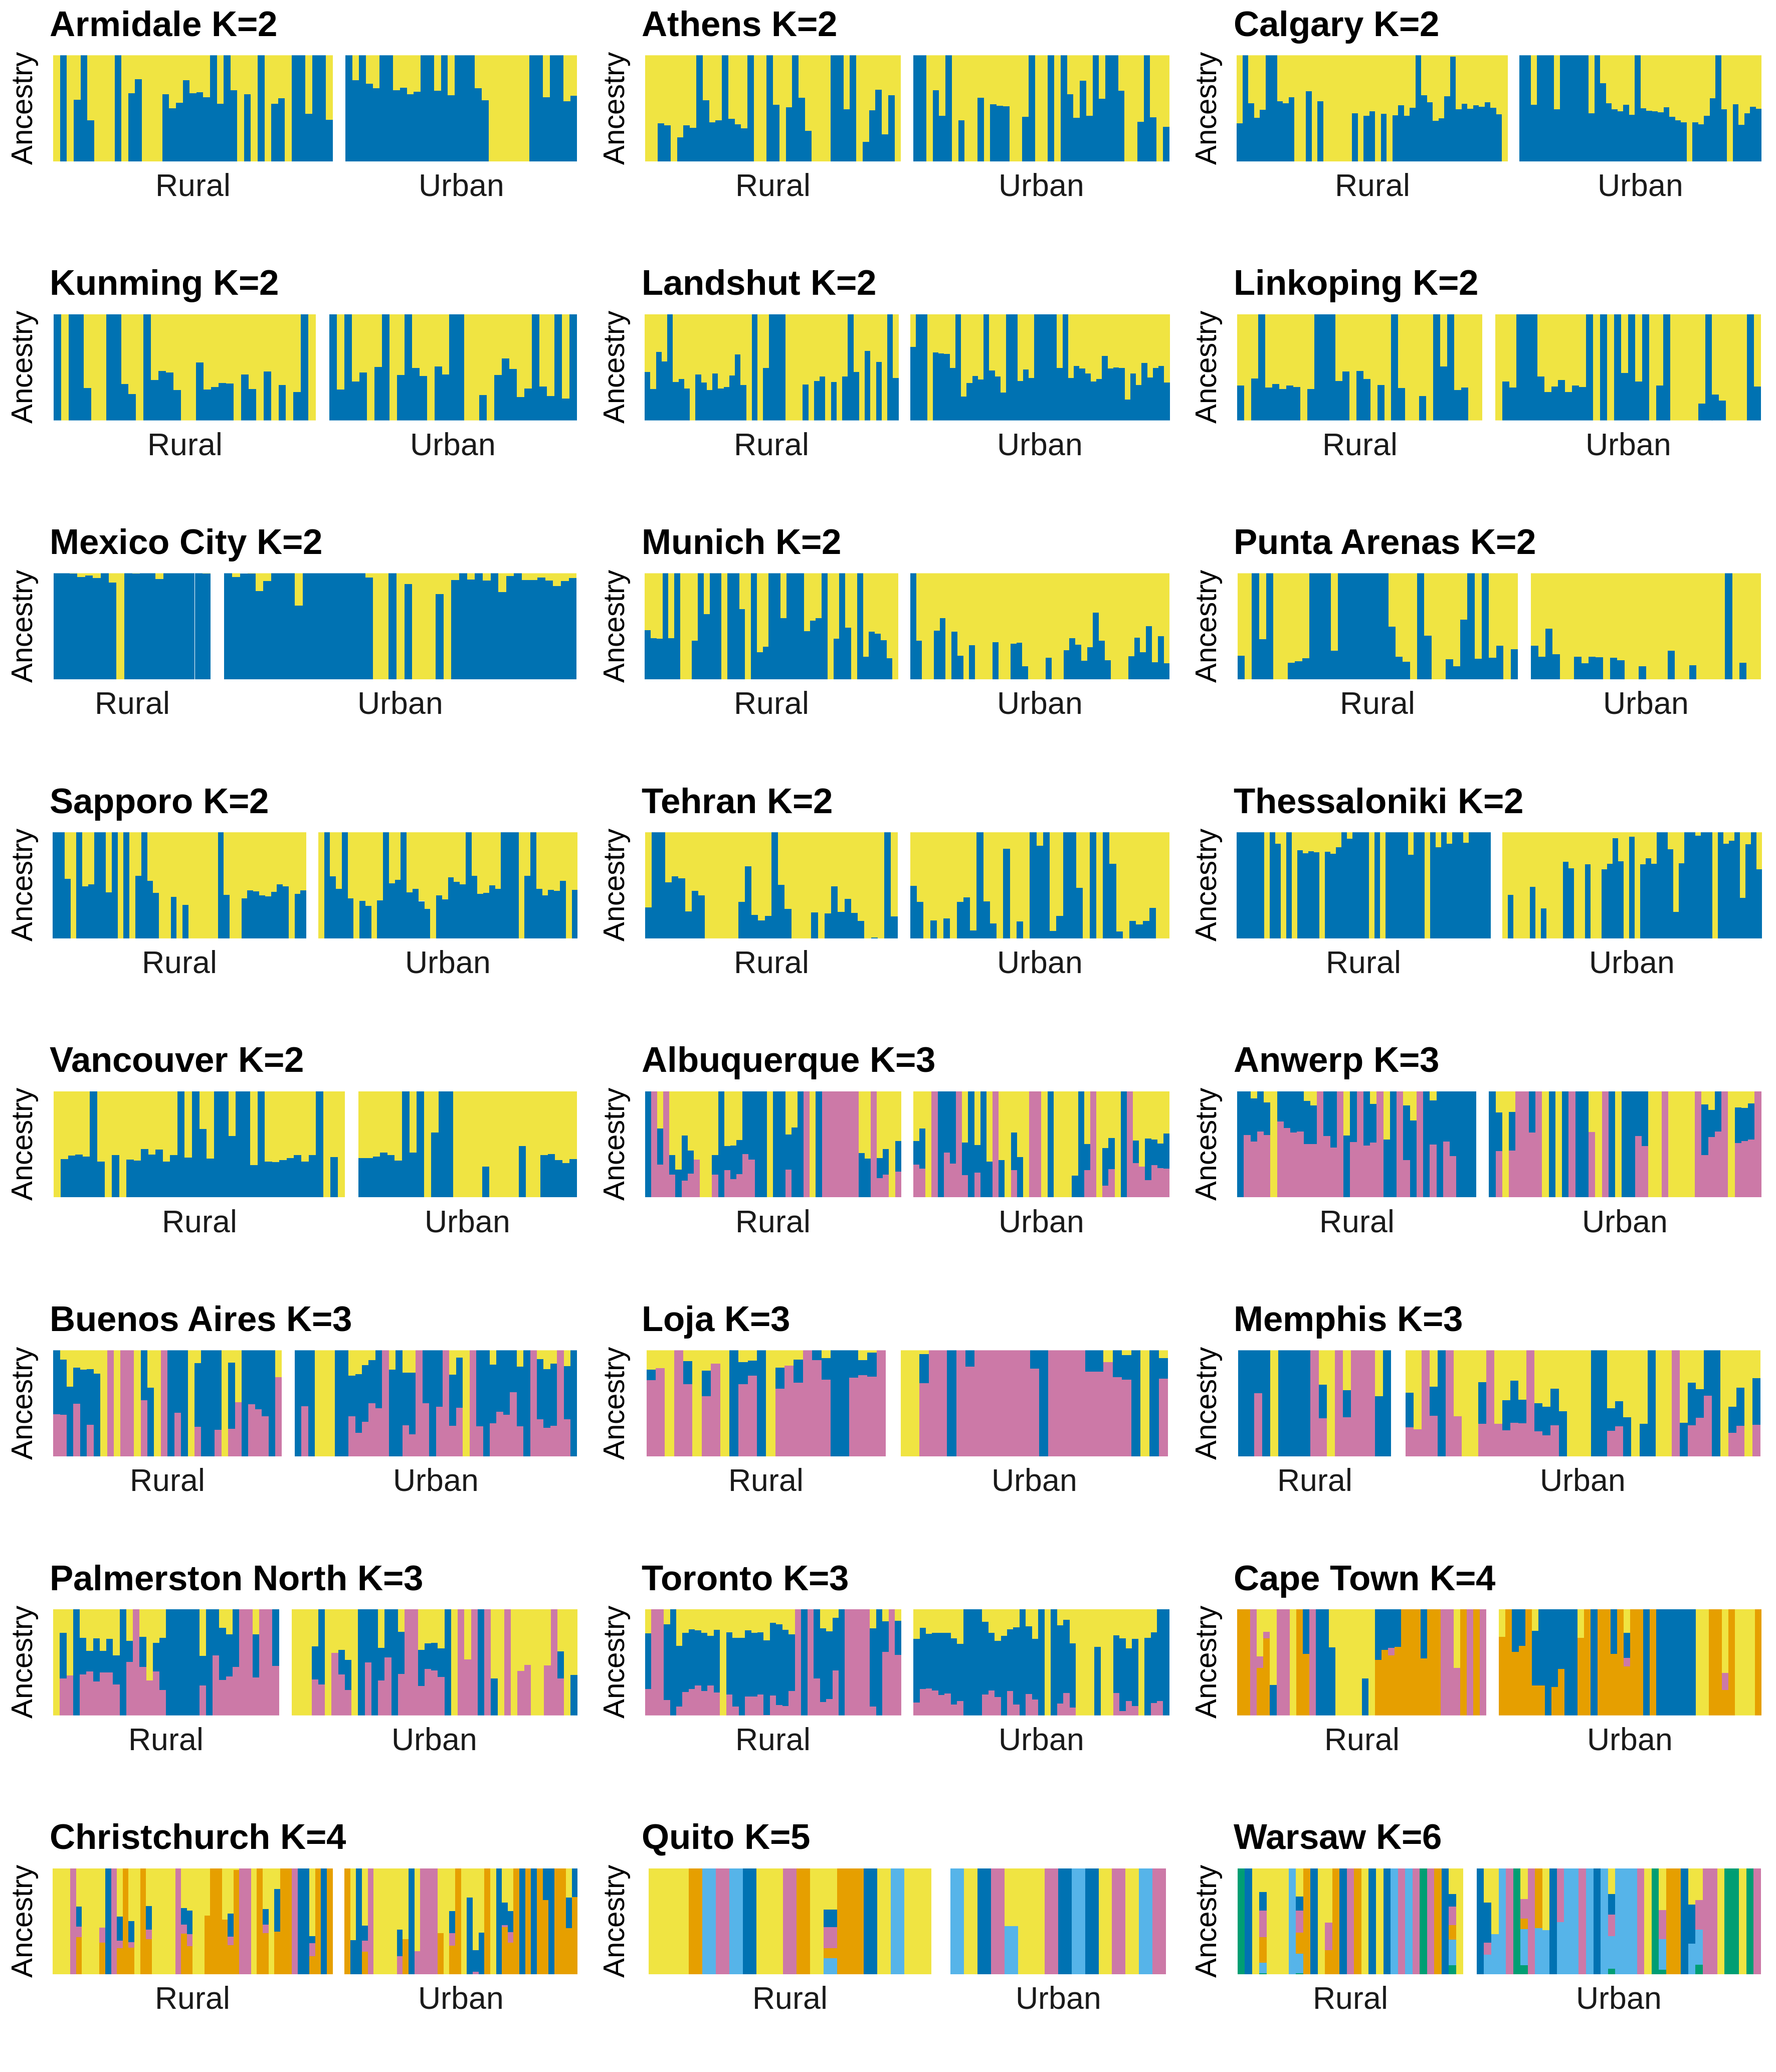

In [81]:
pannel<-ggarrange( kplot_Armidale, kplot_Athens,kplot_Calgary,
                kplot_Kunming, kplot_Landshut, kplot_Linkoping,
                kplot_Mexico_City, kplot_Munich, kplot_Punta_Arenas,
                kplot_Sapporo, kplot_Tehran,kplot_Thessaloniki,
                kplot_Vancouver,
                kplot_Albuquerque, kplot_Antwerp, kplot_Buenos_Aires,
                kplot_Loja, kplot_Memphis, kplot_Palmerston_North,
                kplot_Toronto,
                kplot_Cape_Town, kplot_Christchurch,kplot_Quito,
                kplot_Warsaw,
            ncol=3,nrow=8)
pannel2<-ggarrange(kplot_Albuquerque, kplot_Antwerp, kplot_Armidale, kplot_Athens,
            kplot_Buenos_Aires,kplot_Calgary, kplot_Cape_Town, kplot_Christchurch,
            kplot_Kunming, kplot_Landshut, kplot_Linkoping, kplot_Loja,
            kplot_Memphis, kplot_Mexico_City, kplot_Munich, kplot_Palmerston_North,
            kplot_Punta_Arenas, kplot_Quito, kplot_Sapporo, kplot_Tehran,
            kplot_Thessaloniki, kplot_Toronto, kplot_Vancouver, kplot_Warsaw,
            ncol=3,nrow=8)
            
ggsave(
    "admixture_global.png",
    plot= pannel,
    device = png,
    path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
    width = 30,
    height = 35,
    units = "cm",
    dpi = 300
    )

path_to_admixtureplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/admixture_global.png"
display_png(file=path_to_admixtureplot)

    
    
    
    
    
    
    

# Global admixture

In [82]:
samples<-as.data.frame(read.table("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t"))
samples$site<-gsub("u","tem",as.character(samples$site))
samples$site<-gsub("r","Rural",as.character(samples$site))
samples$site<-gsub("tem","Urban",as.character(samples$site))

detail <- read.table(paste0("/scratch/projects/trifolium/glue/demography/glue_demography/results/program_resources/bam_lists/withoutRelated/finalSamples_4fold_bams.list"))
detail$V1<-gsub("/scratch/projects/trifolium/glue/pc/results/bam/4fold/","",as.character(detail$V1))
detail$V1<-gsub("_4fold.bam","",as.character(detail$V1))
global_detail <-merge(samples, detail,  by.x="sample", by.y="V1", all.x=FALSE, all.y=TRUE, sort=FALSE) 
head(global_detail)


,sample,continent,city,pop,individual,site,range,library,lane,city_pop
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
1,Albuquerque_29_5,NAM,Albuquerque,29,5,Rural,Introduced,glue_low1,1,Albuquerque_.29
2,Albuquerque_29_9,NAM,Albuquerque,29,9,Rural,Introduced,glue_low1,1,Albuquerque_.29
3,Albuquerque_32_13,NAM,Albuquerque,32,13,Rural,Introduced,glue_low1,1,Albuquerque_.32
4,Albuquerque_32_3,NAM,Albuquerque,32,3,Rural,Introduced,glue_low1,1,Albuquerque_.32
5,Albuquerque_33_2,NAM,Albuquerque,33,2,Rural,Introduced,glue_low1,1,Albuquerque_.33
6,Albuquerque_33_7,NAM,Albuquerque,33,7,Rural,Introduced,glue_low1,1,Albuquerque_.33


[1] "Wed Dec  7 14:04:28 2022: Optimal K by Evanno is: 3"

[1] "3"

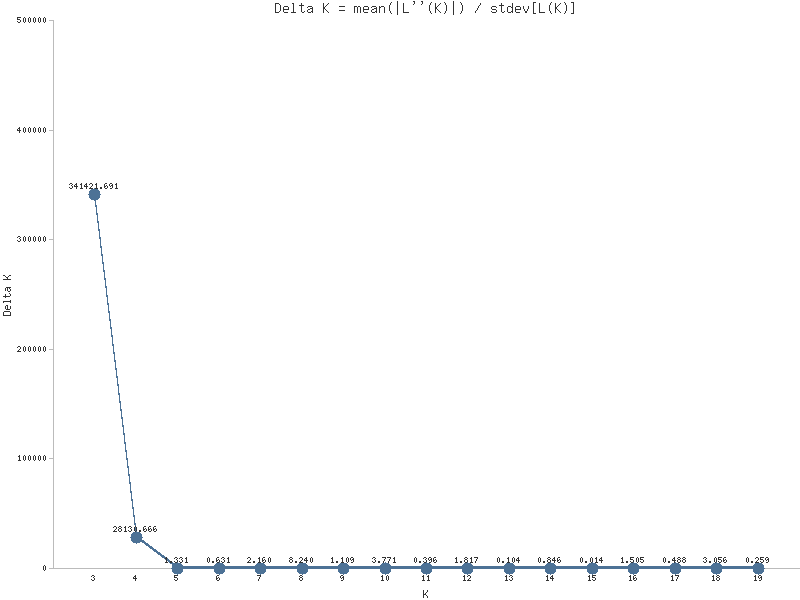

In [6]:
city <- 'global'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])

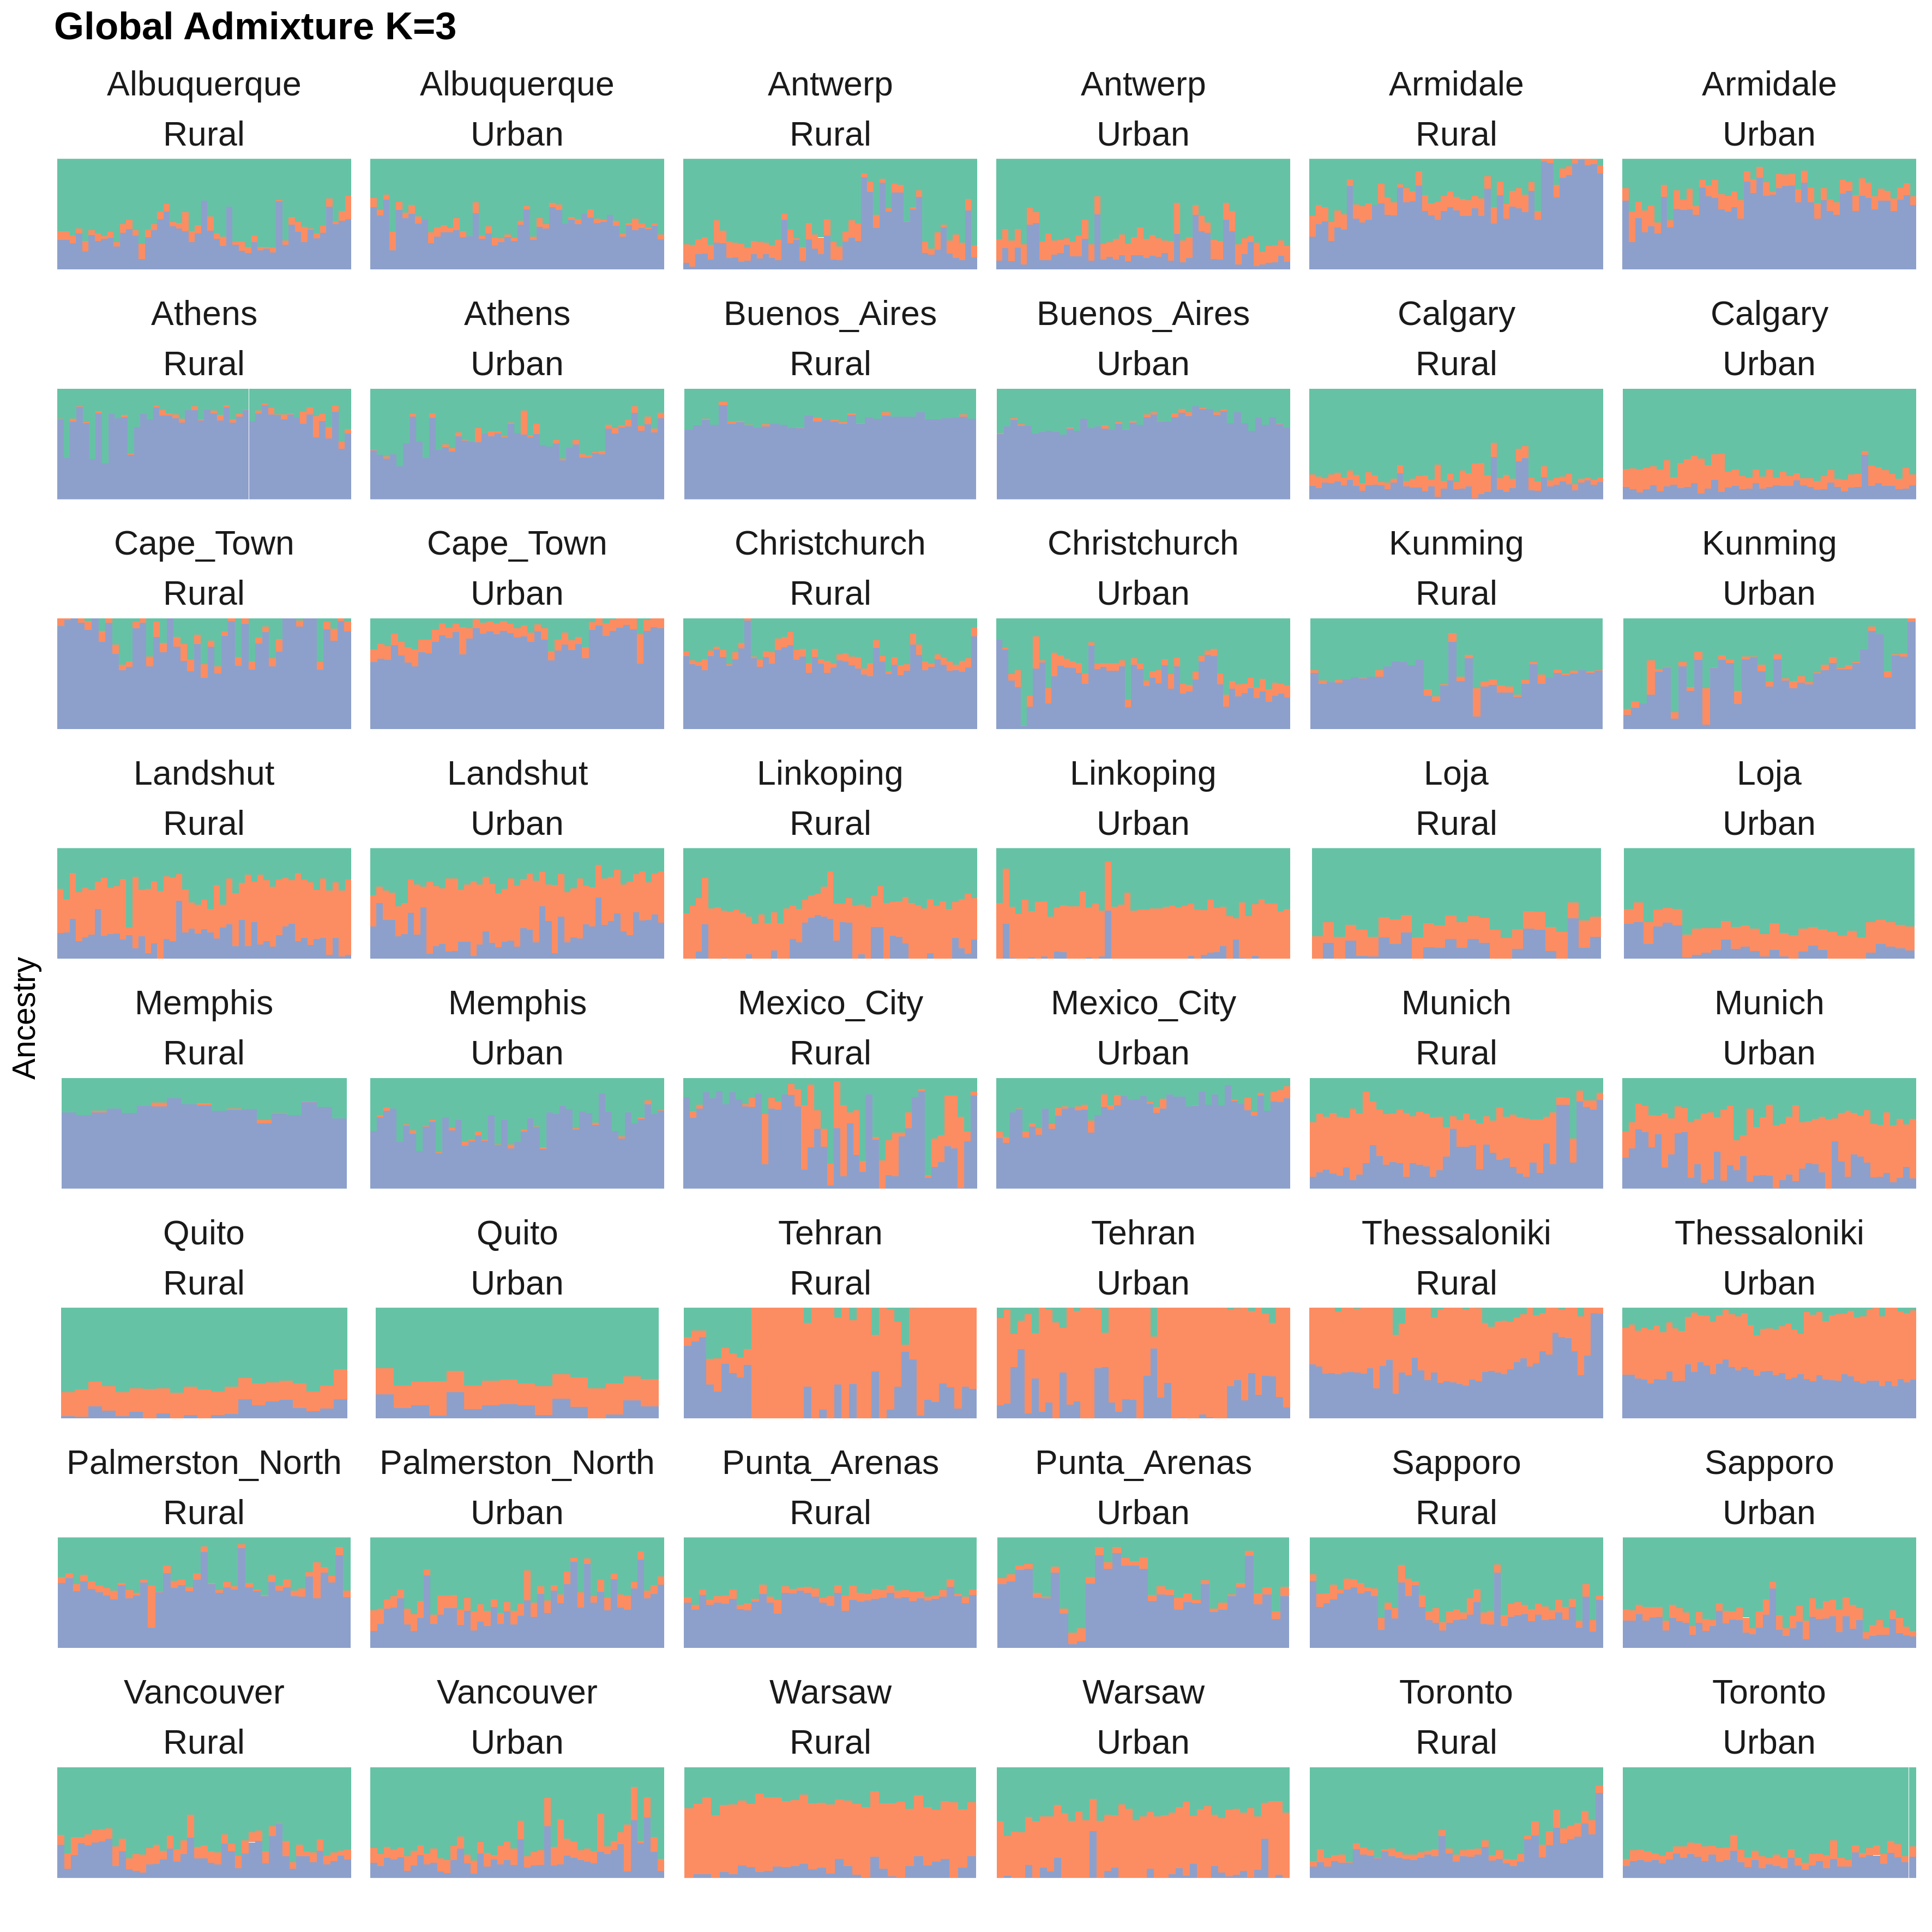

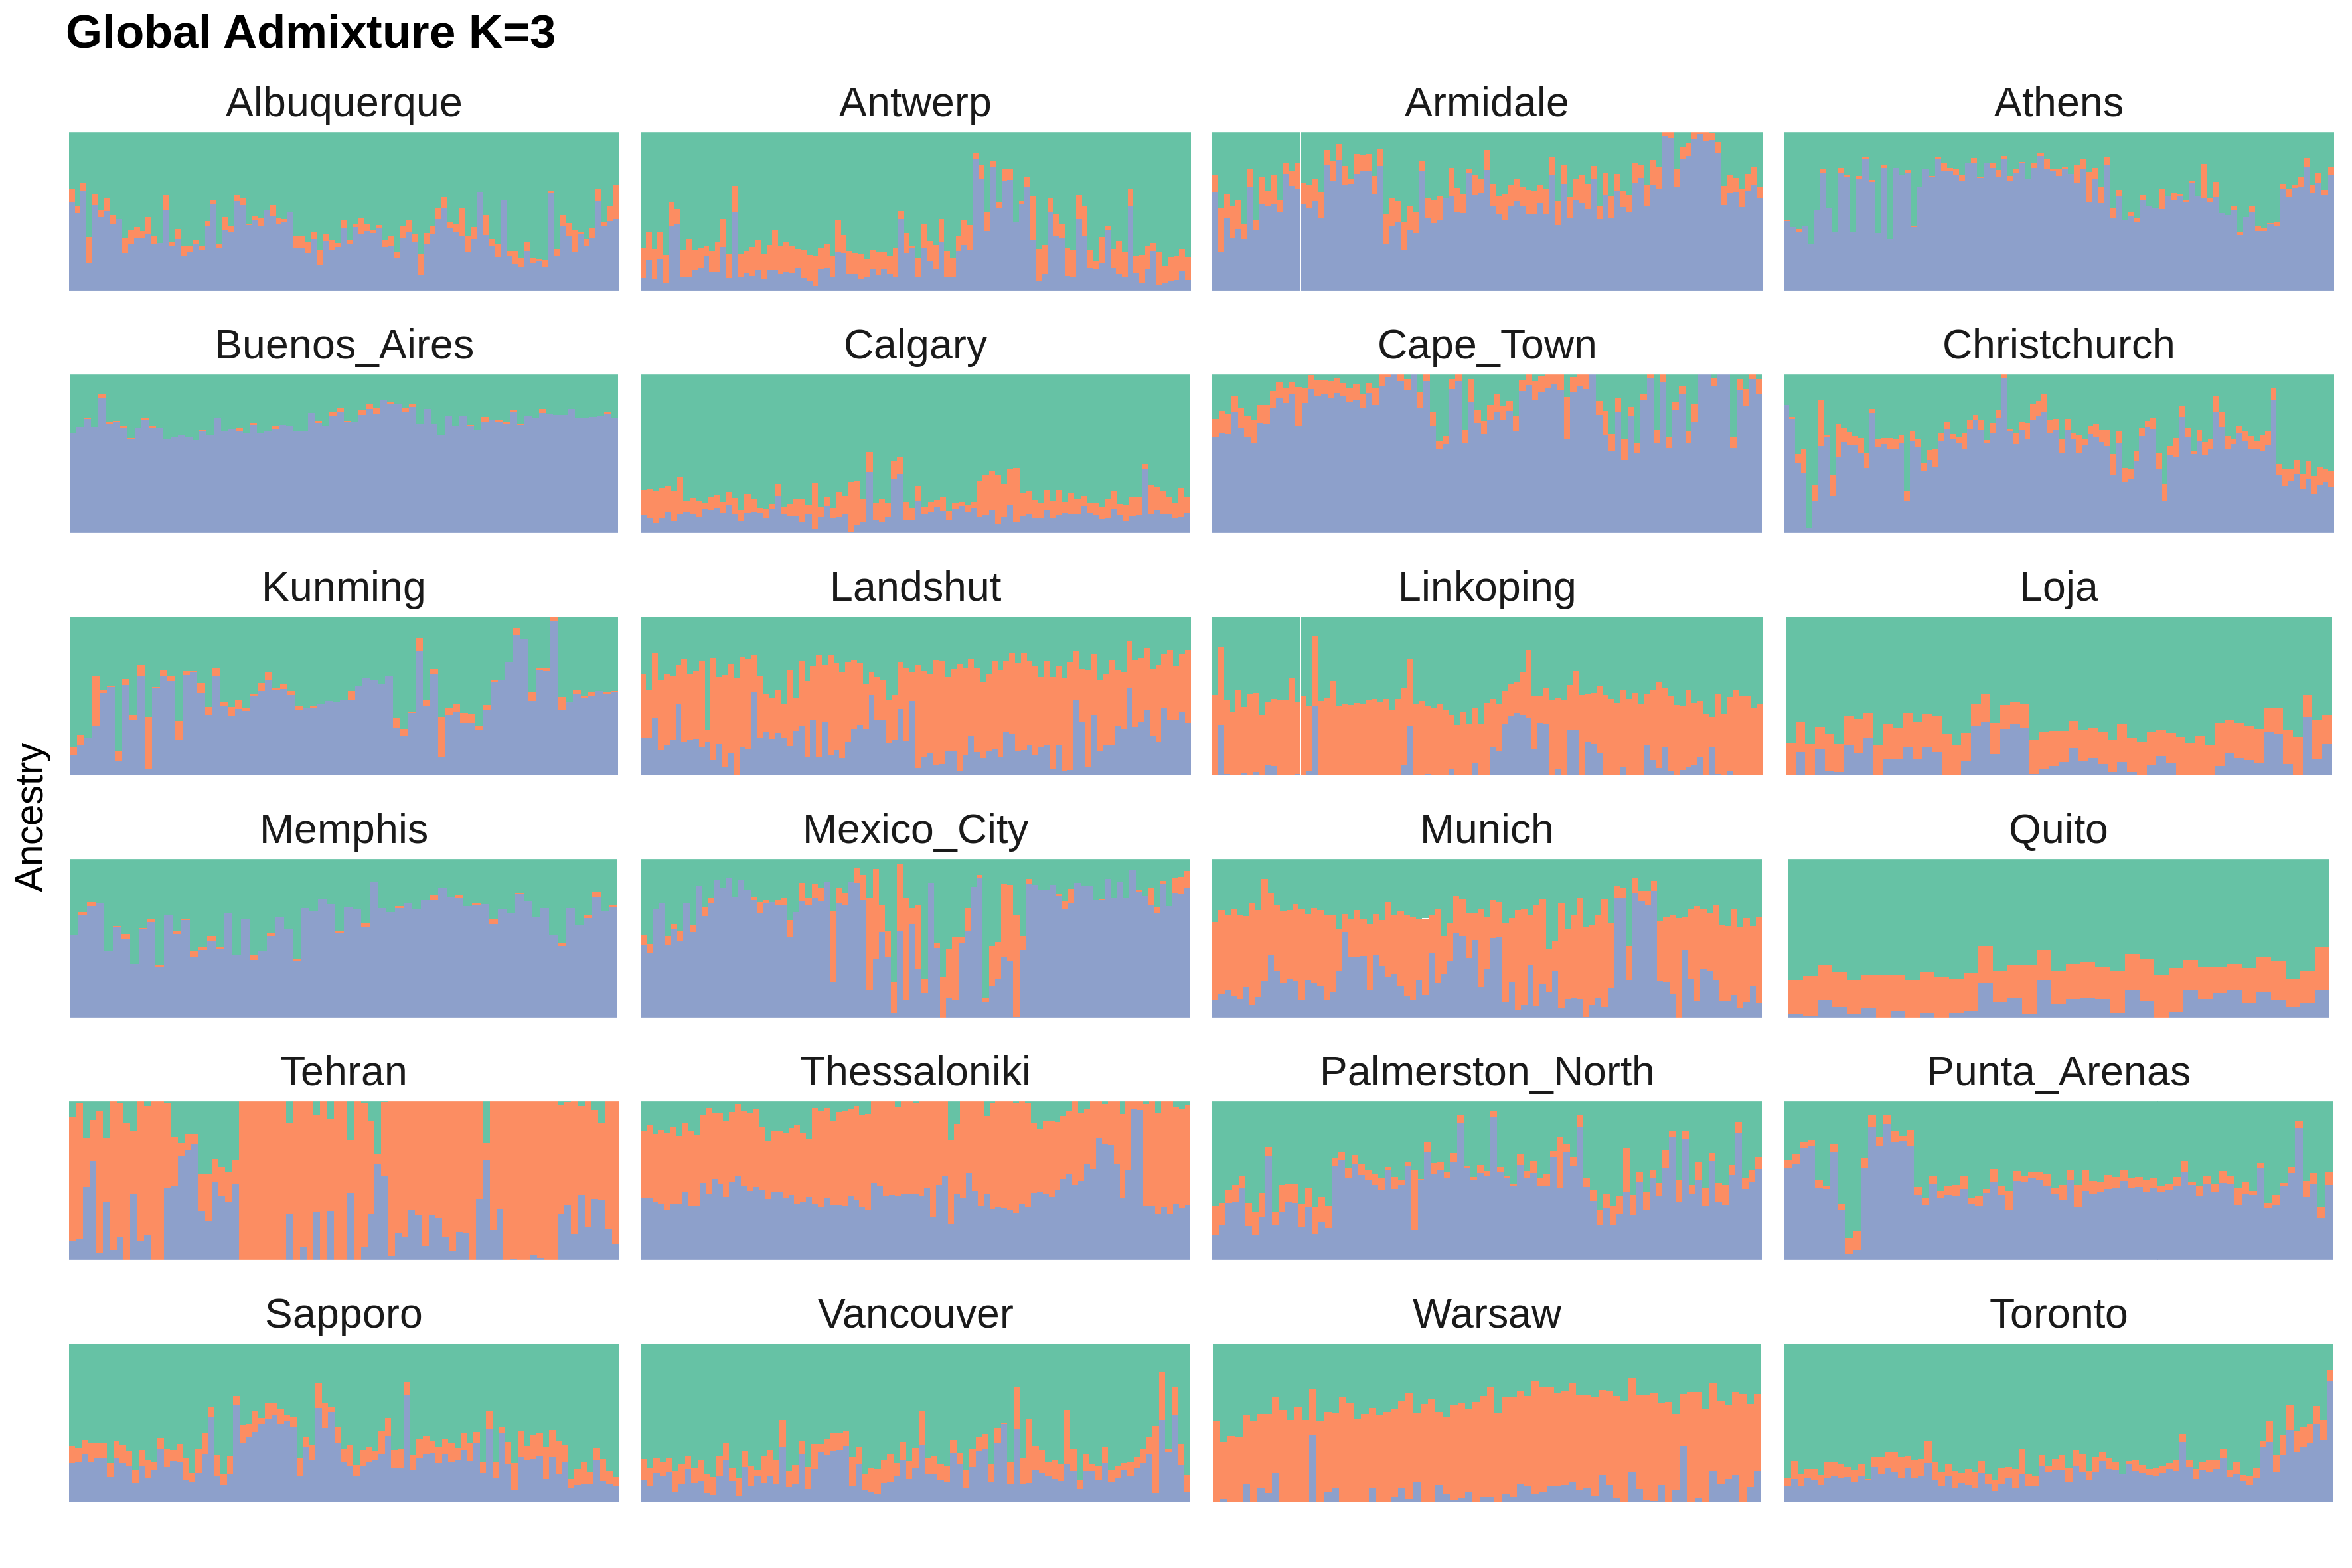

In [32]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., global_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_global_city_hab <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_wrap(~fct_inorder(city)*site, scales = "free",ncol=6) +
  theme_minimal() + labs(x="",title = "Global Admixture K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Global_city_hab_K3.png",
  plot = kplot_global_city_hab,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 30,
  height = 30,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Global_city_hab_K3.png"
display_png(file=path_to_kplot)

kplot_global_city <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_wrap(~fct_inorder(city), scales = "free",ncol=4) +
  theme_minimal() + labs(x="",title = "Global Admixture K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Global_city_K3.png",
  plot = kplot_global_city,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 30,
  height = 20,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Global_city_K3.png"
display_png(file=path_to_kplot)
